# System

This work is focused on extending our previous ideas to network-wide beam management through minimal shared information and hybrid dual polarized arrays.

In [ ]:
import tensorflow as tf
tf.__version__

'2.13.1'

In [ ]:
import numpy as np
import numba
import time
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import h5py
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "colab"
from statsmodels.distributions.empirical_distribution import ECDF
import sys
import datetime
import inspect
from math import sqrt
import logging
import cProfile
import seaborn as sns
from sklearn.model_selection import train_test_split
from functools import partial
from itertools import cycle, product
import gc
import cProfile
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False

import sionna

from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel # CIRDataset


logger = logging.getLogger("numba");
logger.setLevel(logging.ERROR)

np.set_printoptions(precision=3)

indexer = 1

gpu_mem = tf.config.list_physical_devices('GPU')[0]
gpu2_mem = tf.config.list_physical_devices('GPU')[1]

tf.config.experimental.set_memory_growth(gpu_mem, True)
tf.config.experimental.set_memory_growth(gpu2_mem, True)

gpu = tf.config.list_logical_devices('GPU')[0]
gpu2 = tf.config.list_logical_devices('GPU')[1]

path = 'network_XMIMO_{}/'.format(indexer) 
if os.name != 'nt':
    path = r'network_XMIMO_{}/'.format(indexer)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import mixed_precision
    # policy = mixed_precision.Policy('mixed_float16')
    # mixed_precision.set_global_policy(policy)
    # import keras_tuner

    from keras import backend as K
    print("tf version = ",tf.__version__)
    print(tf.config.list_physical_devices())

    !nvidia-smi

2024-02-21 22:29:42.373070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version =  2.11.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Wed Feb 21 22:29:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0C:00.0 Off |                  N/A |
|  0%   30C    P2   106W / 430W |    476MiB / 24576MiB |      1%      Default |
|                           

In [ ]:
# constants
pi = np.pi
fc = 10e9
ctype = np.complex64
Nx = 16
Ny = 16
Nt = Nx*Ny
Nr = 4
C = 3

Nx1 = 16
Ny1 = 16
Lmax = 16

theta_steps = Nx1
phi_steps = Ny1

Nxd = 8
Nyd = 4
b_phaseshifter = 2

theta_min = 3*pi/24
theta_max = 21*pi/24
phi_min = 3*pi/24
phi_max = 21*pi/24

thetas = np.linspace(theta_min, theta_max, num=theta_steps) # / 180 * np.pi
# symmetric about 0-180/180-360 by ULA processing
phis = np.linspace(phi_min, phi_max, num=phi_steps) #/ 180 * np.pi

subcarrier_spacing = 30e3*12 # RB spacing
Ktotal = 20

batch_size=32

matplotlib.rcParams['figure.figsize'] = [3.25, 2.5]
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['lines.linewidth'] = 3

In [ ]:
# utility functions
from sklearn.neighbors import KernelDensity


def pdf_plot(data, xmin=0, xmax=15, label="", markers='-*', markevery=1000, bw=0.25):
    x_d = np.linspace(xmin, xmax, 2000)
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(data[:, None])
    logprob = kde.score_samples(x_d[:, None])
    # plt.fill_between(x_d, np.exp(logprob), alpha=0.5, label=label, )
    plt.plot(x_d, np.exp(logprob), markers, markevery=markevery, label=label)
    return np.exp(logprob)


def cdf_plot(data, label="", markers='-*', markevery=1000):
    ecdf = ECDF(data)
    plt.plot(ecdf.x, ecdf.y, markers, label=label, markevery=markevery)
    return ecdf


def logx(x):
    return 10*np.log10(x)

@tf.function()
def tf_10log10(x):
  numerator = tf.math.log(x+1e-15)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return 10*numerator / denominator

def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def np_kmax(array, k):
    # returns the K-max points from an array
    indices = np.argpartition(array, -k)[-k:]
    return array[indices]

def np_kargmax(array, k):
    indices = np.argpartition(array, -k)[-k:]
    return indices

def smoothing_filter(x, N=20):
    """
    Applies an N-point smoothing filter to data, generally for plotting. Data at the end of the array has less smoothing
    :param x: 1D data
    :param N: Number of samples to use for the moving filter
    :return: smoothed 1D data of equal size
    """
    xcopy = x.copy()
    xcopy[:-N+1] = np.convolve(x, np.ones(N)/N, mode='valid')
    for i in range(1, N):
        xcopy[-i] = np.mean(xcopy[-N+i:])
    return xcopy

@numba.jit(nopython=True)
def nb_mean_0(tensor):
    units = tensor.shape
    outputs = np.zeros((units[1:]), dtype=ctype)
    for i in numba.prange(units[0]):
        outputs = outputs + tensor[i]
    return outputs/units[0]

@numba.jit(parallel=True, nopython=True)
def nb_det(tensor):
    outputs = np.zeros((len(tensor)), dtype=ctype)
    for i in numba.prange(len(tensor)):
        outputs[i] = np.linalg.det(tensor[i])
    return outputs

@numba.jit(nopython=True)
def nb_svd(H):
    units = H.shape
    U = np.zeros((units[0], units[1], units[1]), dtype=ctype)
    S = np.zeros((units[0], units[1]), dtype=ctype)
    V = np.zeros((units[0], units[2], units[2]), dtype=ctype)
    for i in numba.prange(len(H)):
        U[i, :, :], S[i, :], V[i, :, :] = np.linalg.svd(H[i])
    return U, S, V

# @numba.jit(fastmath=True, nopython=True)
def array_resp(theta, N, lambda_c=1, d=None):
    """
    Returns the array response for a ULA in direction theta with N antenna elements. Defaults to lambda/2 spacing
    :param theta: Direction of interest for array response
    :param N: Number of antenna elements
    :param lambda_c: wavelength, although this only needs to be relative to d so it is often not necessary.
    :param d: antenna element spacing. Defaults to lamba_c/2.
    :return: the n-point array response of a ULA
    """
    if d is None or d is False:
        d = lambda_c / 2
    n = np.expand_dims(np.arange(N), axis=1)
    vander = np.exp((1j * pi * 2 * n * d * np.cos(theta)) / lambda_c).astype(ctype).T
    return vander


def steering_vectors(thetas, phis, Nx=1, Ny=1, d=0.5):
    # Define the steering vector for a planar array of size Nrx by Nry with spacing (in wavelengths) d.
    # thetas and phis can have size greater than 1 for batch approaches
    n_theta = len(thetas)
    n_phi = len(phis)
    steering_mtx = np.zeros((n_theta, n_phi, Nx, Ny), dtype=np.complex64)
    # print(steering_mtx.shape, array_resp(thetas, Nx, d).shape)
    steering_xs = array_resp(thetas, Nx, d)
    steering_ys = array_resp(phis, Ny, d)
    # Now cross terms to achieve the beamforming matrices
    steering_mtx[:] = np.einsum('ij,kl->ikjl', steering_xs, steering_ys)
    steering_vector = steering_mtx.reshape(n_theta, n_phi, Nx*Ny)
    return steering_vector


@numba.jit(fastmath=True, nopython=True)
def pattern_ijk(theta, phi, Nx, Ny, V):
    x = np.abs(array_resp(phi, Ny) @ V.conj().T @  array_resp(theta, Nx).T)**2

def subgroup_channels(H, subtimes=1, subbands=1):
    # Channel size is made to fit a number of subtimes and subbands for one user
    # returns H_bar in [subtimes, subbands, Nt, Nr]
    if len(H.shape) == 2: # H is just
        H = np.expand_dims(np.expand_dims(H, 0), 0)
    elif len(H.shape) == 3:
        H = np.expand_dims(H, 0)
    elif len(H.shape) != 4:
        raise AssertionError("Error, shape of channels is {H.shape}, but should be 2, 3, or 4 dimensional")
    units = np.array(H.shape).astype(np.int16)  # [time, sc, Nr, Nt]
    # must iteratively split the channel into subbands/subtimes and average to obtain best discrete precoder
    if subbands != units[1]:
        # try:
        H_subbands = np.array_split(H, subbands, axis=1)
        # except Exception:
        #     largest_ind = (H.shape[1]//subbands)*subbands # throw away not-fitting subcarriers/RBs
        #     H_subbands = np.array_split(H[:, :largest_ind], subbands, axis=1)
        H_bar = np.zeros((subbands, units[0], units[2], units[3]), dtype=ctype)
        for i in range(subbands):
            H_bar[i, :, :, :] = nb_mean_0(np.transpose(H_subbands[i][:, :, :, :], (1, 0, 2, 3)))
    else:
        H_bar = H.transpose(1, 0, 2, 3)
    if subtimes != units[0]:
        try:
            H_subbands = np.array_split(H_bar, subtimes, axis=1)  # has shape [subtimes, subbands, Nt, Nr]
        except Exception:
            largest_ind = (H.shape[1]//subtimes)*subtime
            H_subbands = np.array_split(H_bar[:, :largest_ind], subbands, axis=1)
        H_bar = np.zeros((subtimes, subbands, units[2], units[3]), dtype=ctype)
        for i in range(subtimes):
            H_bar[i, :, :, :] = nb_mean_0(np.transpose(H_subbands[i][:, :, :, :], (1, 0, 2, 3)))
    else:
        H_bar = H_bar.transpose(1, 0, 2, 3)
    return H_bar.astype(ctype)



def DFT_codebook(n_beams=8, Nx=4, Ny=8, OH=1, OV=1, **kwargs):
    # DFT where n_beams decides how many beams are given. For n_beams<Nt some antennas are not used at all
    # for wider beams
    test_bf = np.zeros((n_beams, Nx*Ny, 1), dtype=ctype)
    Nt = Nx * Ny
    print(f"Generating codebook for {n_beams} from size {Nx}x{Ny}x{OH}x{OV}")
    if n_beams >= Nx*Ny*OH*OV:
        test_bf[:, :, 0] = gen_codebook(Nx=Nx, Ny=Ny, OH=OH, OV=OV)
    else:
        test_bf = np.zeros((n_beams, Nx, Ny), dtype=ctype)
        if n_beams <= 8:
            Nx1 = 2
        elif n_beams <= 32:
            Nx1 = 4
        else:
            Nx1 = 8
        Ny1 = n_beams//Nx1
        DFT_x = np.fft.fft(np.eye(Nx1)) / np.sqrt(Nx1)
        DFT_y = np.fft.fft(np.eye(Ny1)) / np.sqrt(Ny1)
        for nx in range(Nx1):
            for ny in range(Ny1):
                test_bf[nx*Ny1+ny, Nx//2-Nx1//2:Nx//2+Nx1//2, Ny//2-Ny1//2:Ny//2+Ny1//2] = DFT_x[:, nx:nx+1] @ DFT_y[ny:ny+1, :]
        test_bf = test_bf.reshape(n_beams, Nt, 1)

    test_bf = test_bf / np.linalg.norm(test_bf, axis=(1), keepdims=True) * np.sqrt(Nt)
    return test_bf

def gen_codebook(Nx, Ny, OH=1, OV=1, **kwargs):
    # generate codebooks of size [Nx*Ny*OH*OV, Nt] from DFT codebooks
    Nt = Nx * Ny
    zero_pad_eye_y = np.eye(Ny*OV)
    zero_pad_eye_x = np.eye(Nx*OH)
    DFT_y = np.fft.fft(zero_pad_eye_y)[:, :Ny] / np.sqrt(Ny)
    DFT_x = np.fft.fft(zero_pad_eye_x)[:Nx, :] / np.sqrt(Nx)

    all_codebook = np.zeros((Nx*OH*Ny*OV, Nx, Ny), dtype=ctype)
    for i in range(OH*Nx):
        for j in range(OV*Ny):
            all_codebook[i*OV*Ny + j, :, :] = DFT_x[:, i:i+1] @ DFT_y[j:j+1, :]
    all_codebook = all_codebook.reshape(Nx*OH*Ny*OV, Nt).astype(ctype)
    return all_codebook


stx = steering_vectors(thetas, phis, Nx, Ny)

U_NyNy = np.array([array_resp(phis[i], Ny) for i in range(Ny1)]).astype(ctype)[:, 0, :]
U_NxNx = np.array([array_resp(thetas[i], Nx) for i in range(Nx1)]).astype(ctype)[:, 0, :].T

U_NyNy_inv = np.linalg.pinv(U_NyNy)
U_NxNx_inv = np.linalg.pinv(U_NxNx)

U_NyNy = U_NyNy / np.linalg.norm(U_NyNy, 'fro')
U_NxNx = U_NxNx / np.linalg.norm(U_NxNx, 'fro')
U_NyNy_inv = U_NyNy_inv / np.linalg.norm(U_NyNy_inv, 'fro')
U_NxNx_inv = U_NxNx_inv / np.linalg.norm(U_NxNx_inv, 'fro')

tf_U_NyNy = tf.constant(U_NyNy, dtype=tf.complex64)
tf_U_NxNx = tf.constant(U_NxNx, dtype=tf.complex64)
tf_U_NyNy_inv = tf.constant(U_NyNy_inv, dtype=tf.complex64)
tf_U_NxNx_inv = tf.constant(U_NxNx_inv, dtype=tf.complex64)

In [ ]:
scene_id = 'A'
en_scat = False # enables scattering in Sionna
en_diff = True  # enables diffraction in Sionna
scat_prob = 1e-5
C = 3 # number of TX


if scene_id == 'A':
    fc = 10e9
    scene = load_scene(sionna.rt.scene.munich)
    # scene = load_scene()
    my_cam = Camera("my_cam", position=[-250,250,150], look_at=[-15,30,28])
    scene.add(my_cam)
    tx1 = Transmitter(name="tx1", position=[8.5,21,40], orientation=[1.25, 0, 0])
    tx2 = Transmitter(name="tx2", position=[280,275,40], orientation=[-2*np.pi/3-0.25, 0, 0])
    tx3 = Transmitter(name="tx3", position=[-292,295,40], orientation=[-np.pi/3+0.25, 0, 0])

    rx = Receiver(name="rx", position = [0, 0, 1.5])
    rx.look_at(tx1)
elif scene_id == 'B':
    fc = 20e9
    scene = load_scene(sionna.rt.scene.etoile)
    my_cam = Camera("my_cam", position=[-250,250,150], look_at=[-15,30,28])
    scene.add(my_cam)
    tx1 = Transmitter(name="tx1", position=[-240,-80,30])
    tx2 = Transmitter(name="tx2", position=[140,-130,27], orientation=[2.15, 0, 0])
    tx3 = Transmitter(name="tx3", position=[80, 180,27], orientation=[-1.75, 0, 0])
    rx = Receiver(name="rx", position = [0, 0, 1.5])
    rx.look_at(tx1)
else:
    scene = load_scene()
    tx1 = Transmitter(name="tx1", position=[-33, 11., 32], orientation=[1.25, 0, 0])
    tx2 = Transmitter(name="tx2", position=[-33, 11., 32], orientation=[1.25, 0, 0])
    tx3 = Transmitter(name="tx3", position=[-33, 11., 32], orientation=[1.25, 0, 0])

    rx = Receiver(name="rx", position = [0, 0, 1.5])

scene.frequency = fc
scene.add(tx1)
scene.add(tx2)
scene.add(tx3)
scene.add(rx)

isd = np.mean([np.linalg.norm(tx1.position-tx2.position), np.linalg.norm(tx1.position-tx3.position), np.linalg.norm(tx2.position-tx3.position)])
print(f"ISD = {isd:.1f}m")

scene.tx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="tr38901",
                            polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="iso",
                            polarization="V")


scene.synthetic_array = True
cm_size = (600, 400.)
center_loc = np.array(np.mean([tx1.position, tx2.position, tx3.position], axis=0))
center_loc[-1] = 1.5
# center_loc = [0, 0, 0]
cm = scene.coverage_map(max_depth=5, cm_cell_size=(5, 5), cm_size=cm_size, cm_center=center_loc, cm_orientation=(0, 0, 0.), num_samples=10e6, scattering=en_scat, diffraction=en_diff)

ISD = 450.3m


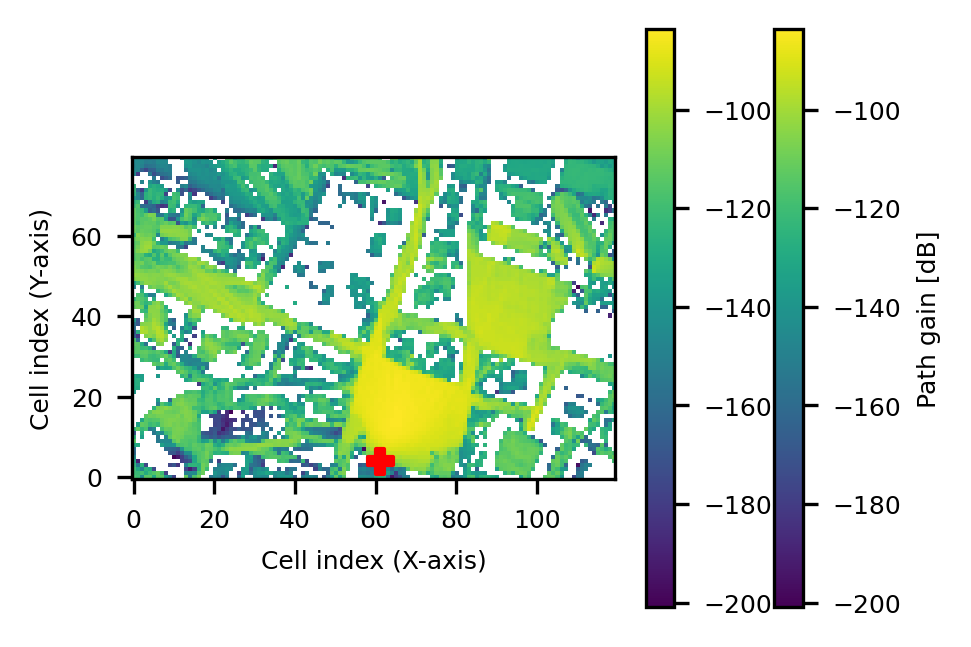

In [ ]:
# for i in range(3):
cm.show(tx=0);
# plt.colorbar()

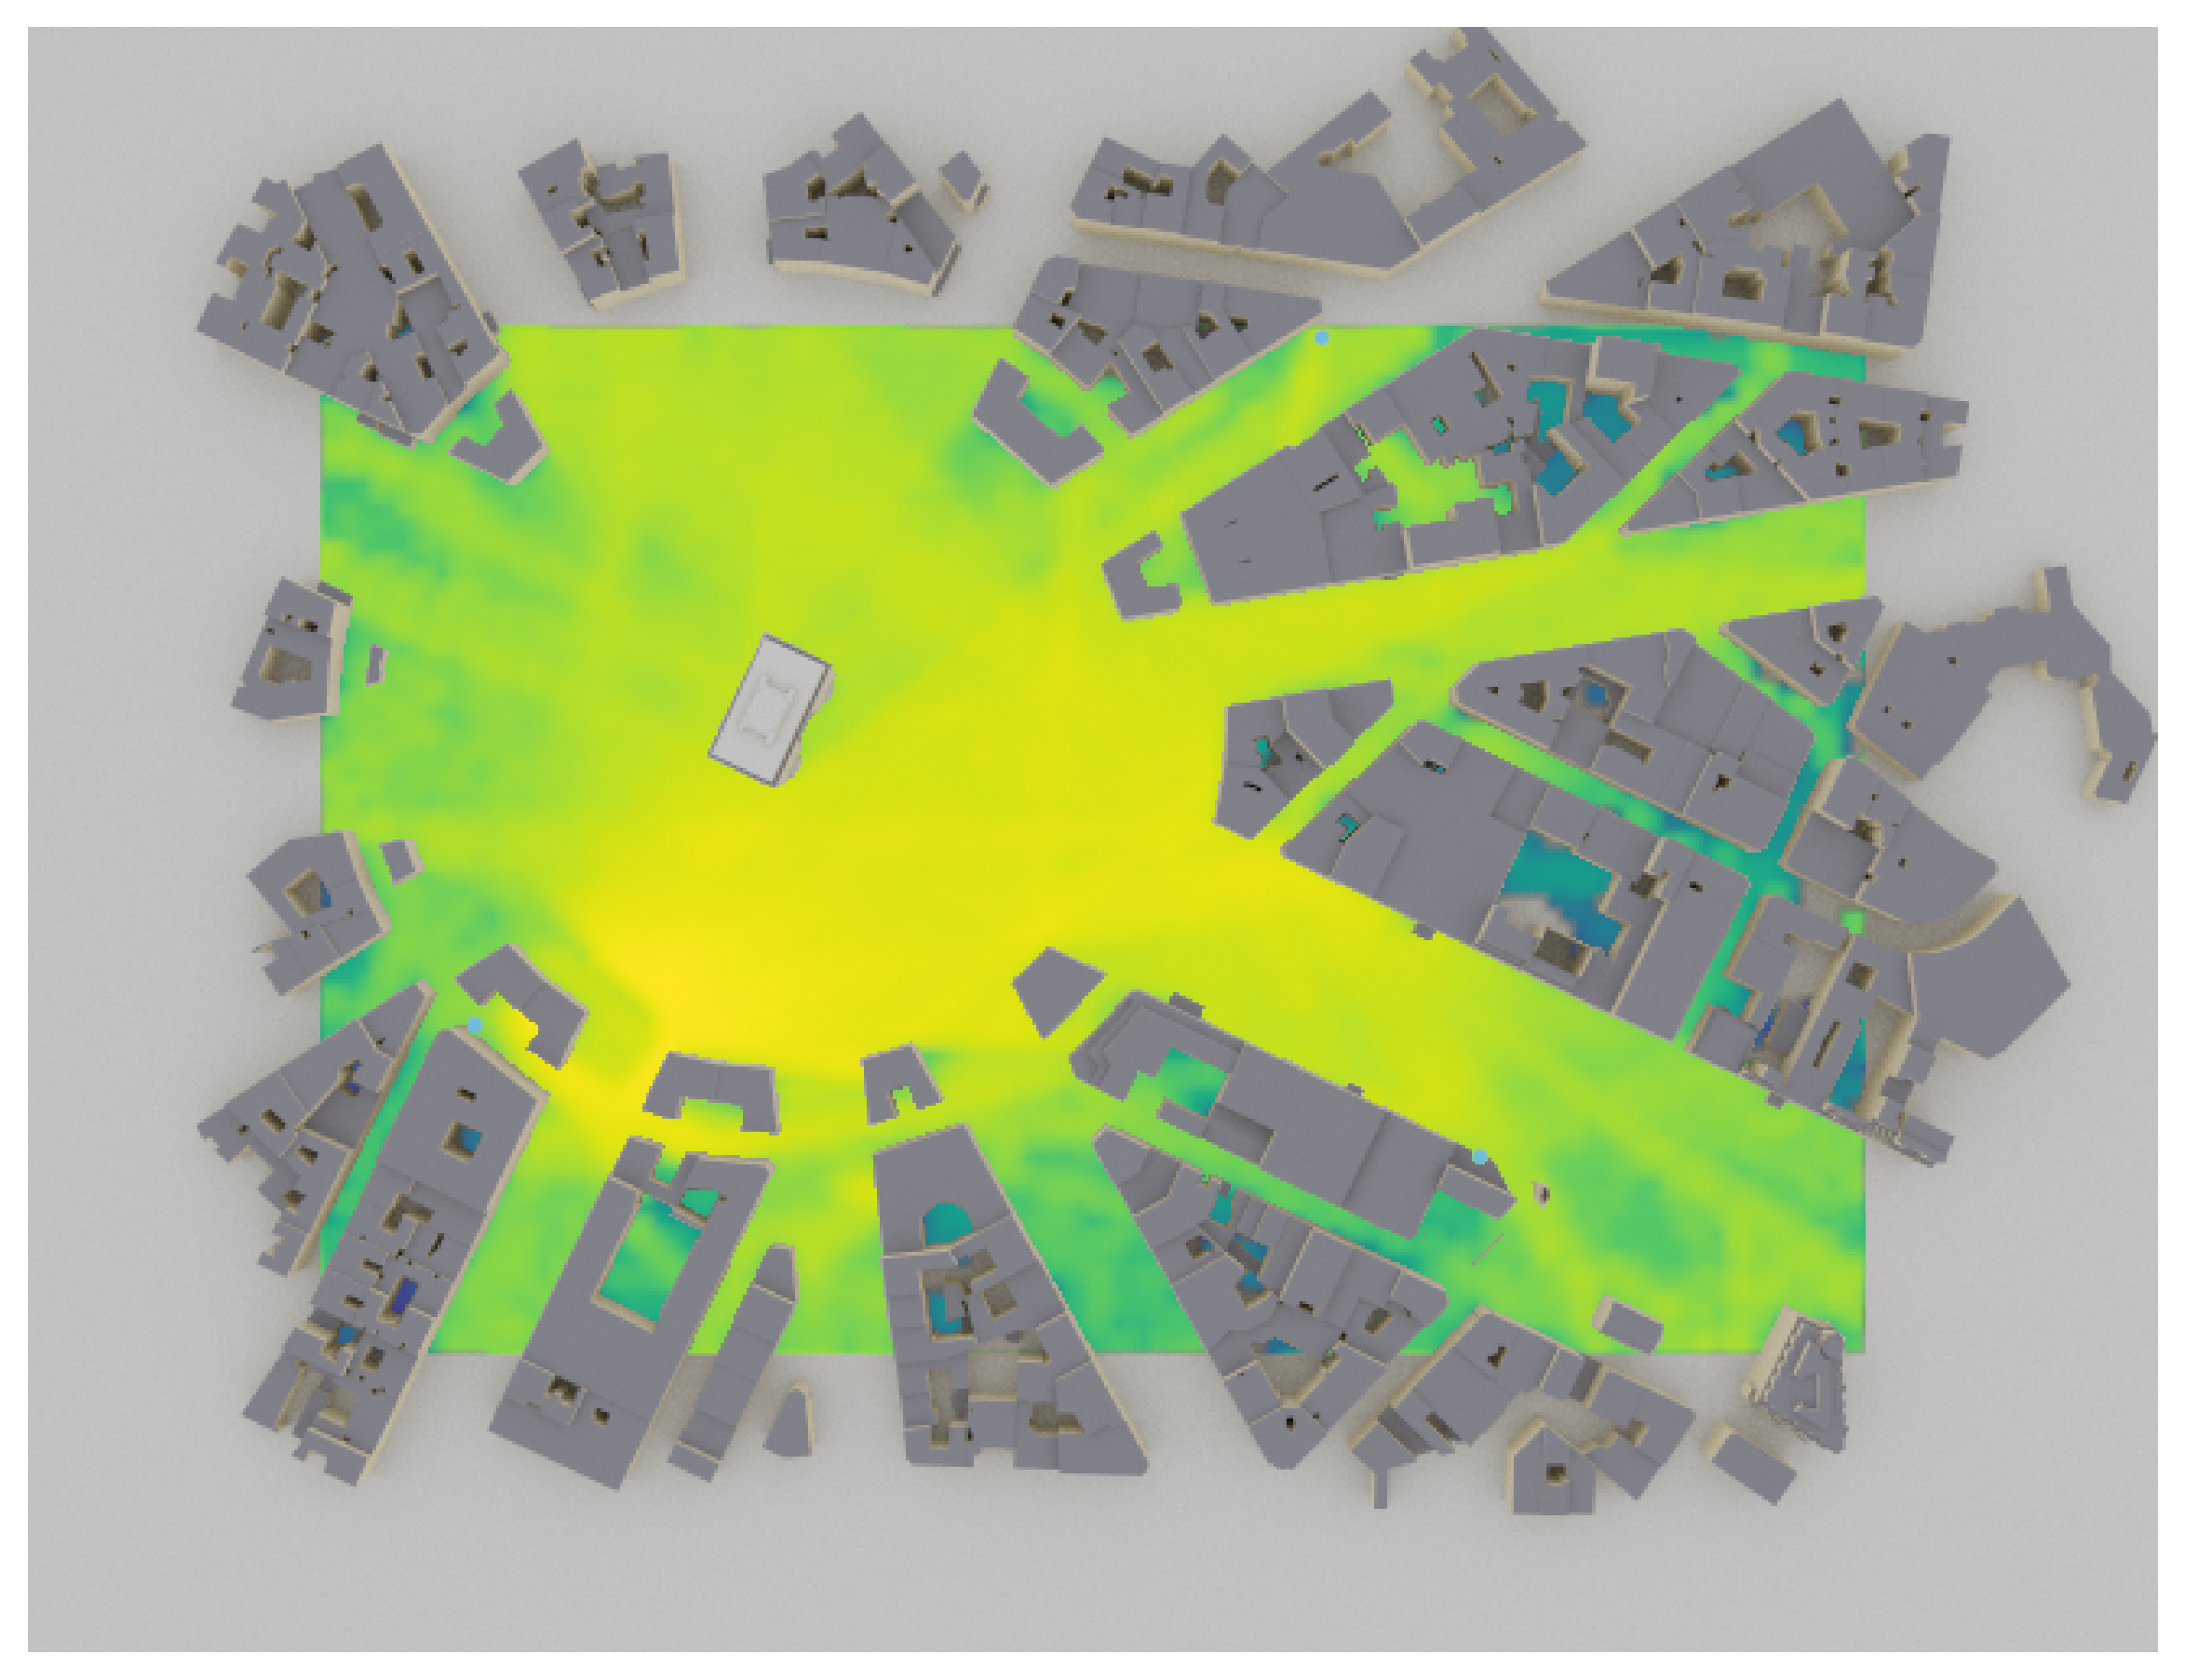

In [ ]:
scene.remove('rx')
tx_pos = scene.transmitters["tx1"].position.numpy()
bird_pos = center_loc.copy()
bird_pos[-1] = 1000 # Set height of coverage map to 1000m above tx
bird_pos[-2]-= 0.01 # Slightly move the camera for correct orientation

bird_cam = Camera("birds_view", position=bird_pos, look_at=center_loc)

scene.render(camera=bird_cam, num_samples=512, coverage_map=cm, cm_tx=0, cm_show_color_bar=False);

In [ ]:
path

'/media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/'

In [ ]:
scene.tx_array = PlanarArray(num_rows=Ny,
                            num_cols=Nx//2,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="tr38901",
                            polarization="VH")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=Nr//2,
                            num_cols=1,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="tr38901",
                            polarization="cross")

scene.receivers['rx'].position = [40, 40, 1.5]

#### mini exploration

In [ ]:
paths = scene.compute_paths(max_depth=4, num_samples=10e5, diffraction=en_diff, scattering=en_scat, scat_keep_prob=scat_prob)
paths.apply_doppler(sampling_frequency=1e3, # 1ms samples
                    num_time_steps=9, # Number of OFDM symbols
                    rx_velocities=[1.5,1.5,0]) # Or rx speeds

frequencies = subcarrier_frequencies(Ktotal, subcarrier_spacing)

a, tau = paths.cir()
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)

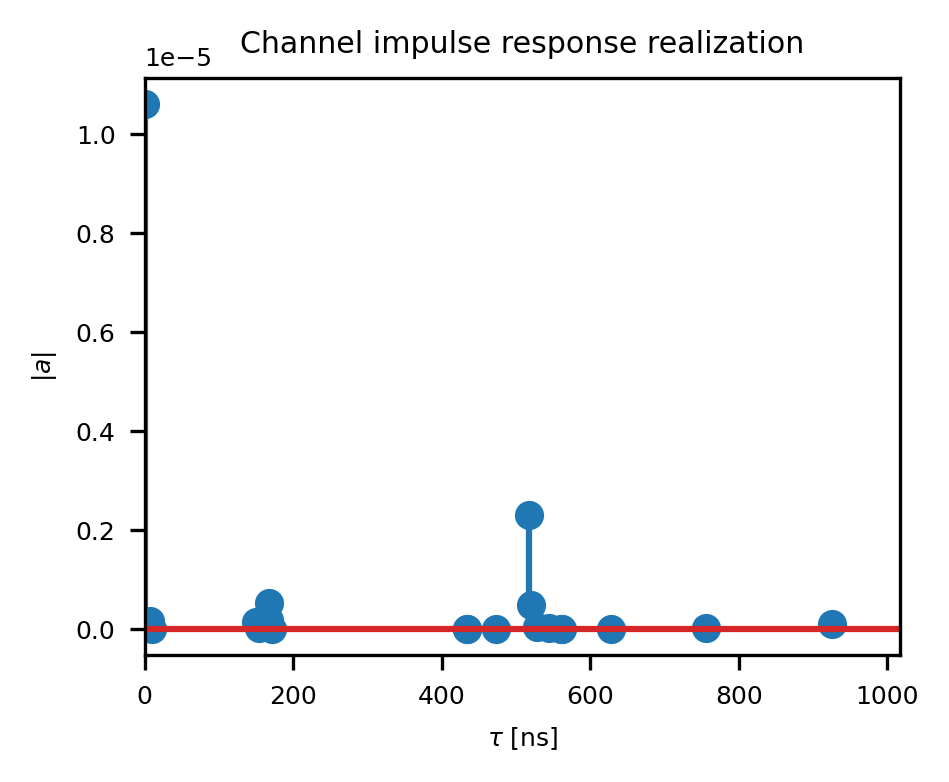

In [ ]:
c_idx = 0

t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,c_idx,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
# plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

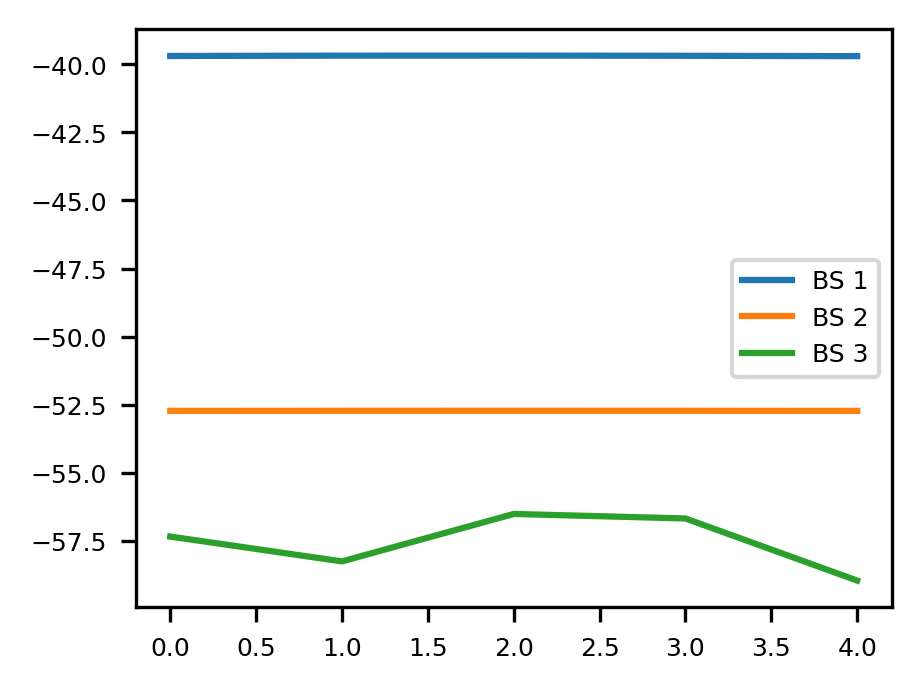

In [ ]:
h_freq.shape # [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
norm_h = np.linalg.norm(h_freq[0, 0], axis=(0, 2)) # C, T, K
for i in range(3):
    plt.plot(logx(norm_h[i, 0]), label=f"BS {i+1}")
plt.legend()

In [ ]:
H_test = np.random.randn(4, 4) + 1j*np.random.randn(4, 4)
S = np.linalg.svd(H_test, compute_uv=False)
print(np.log2(S**2))
print(np.log2(np.linalg.det(H_test@H_test.conj().T)))

[ 4.277  3.425  0.759 -1.356]
(7.105363558981331+8.008566259537295e-16j)


In [ ]:
H_test = tf.Variable(H_test)

In [ ]:
%%timeit -n 5000 -r 5
tf.linalg.svd(H_test, compute_uv=False)

260 µs ± 20.2 µs per loop (mean ± std. dev. of 5 runs, 5000 loops each)


In [ ]:
%%timeit -n 5000 -r 5
tf.linalg.det(H_test@tf.linalg.adjoint(H_test))

677 µs ± 204 µs per loop (mean ± std. dev. of 5 runs, 5000 loops each)


In [ ]:
np.sum(np.log2(S**2))

7.105363558981333

#### back to code

In [ ]:
def path2beamspace(paths, theta_steps=theta_steps, phi_steps=phi_steps):
    """
    Like postprocessing_function from before that decides what the desired outputs are from the paths
    """
    eps = 1e-10
    a, tau = paths.cir() # [?, n_rx, Nrx*Nry, n_tx, Nt, paths]import cProfile
    # need to operate for each path and each n_rx
    a = a[0, :, :, 0, 0, :, 0] # [n_rx, Nt, paths]
    a = a / a[:, 0:1, 0:1] # normalize to the first antenna
    n_rx, Nr, n_paths = a.shape

    responses = np.zeros((n_rx, theta_steps, phi_steps, n_paths), dtype=np.complex64)
    responses[:] = np.einsum('ijn,mnp->mijp', stx.conj(), a)
    responses = 10*np.log(np.sum(abs(responses)+eps, axis=-1)) # sum the absolute of the path responses

    # This is the output where n_rx is the batch dimension and the output is a grid of theta_steps by phi_steps
    return responses


def remove_scene_UEs(scene):
    x_names = list(scene.receivers.keys())
    [scene.remove(x_names[i]) for i in range(len(x_names))] # remove all RX
    # list comprehension to add users up to batch_size
    return scene


def add_scene_UEs(scene, N=1):
    [scene.add(Receiver(name=f"rx00{i}", position=[0., 0., 0.])) for i in range(N)]
    return scene


frequencies = subcarrier_frequencies(Ktotal, subcarrier_spacing)


def scene2channels(scene, timeslots_ms=1, K=20):
    # gets the timevarying, frequency domain channel response for the users
    velocities = np.random.randn(2)*2

    paths = scene.compute_paths(max_depth=5, num_samples=1e6, diffraction=en_diff, scattering=en_scat, scat_keep_prob=scat_prob)
    paths.apply_doppler(sampling_frequency=1e3, # 1ms samples
                    num_time_steps=timeslots_ms, # Number of OFDM symbols
                    rx_velocities=[velocities[0],velocities[1],0]) # Or rx speeds

    a, tau = paths.cir()
    h_freq = cir_to_ofdm_channel(frequencies[:K], a, tau, normalize=False)
    # return h_freq[0, :, :, 0, :, :, :] # strip to [U, Nr, Nt, T, K]
    return h_freq[0] # strip to [U, Nr, C, Nt, T, K]


def rsrp_rx_comb(H, beams):
    #  H [Nr, Nt], beams is [Lmax, Nt, 1]
    # returns SSBRI, RSRP, assuming fully digital combining
    C, Lmax, Nt, _ = beams.shape
    # rsrp_per_sc_nr = np.zeros((Lmax,),dtype=ctype)
    rsrps = np.zeros((C, Lmax,), dtype=np.float32)
    for c in range(C):
        for beam in numba.prange(Lmax):
            rsrps[c, beam] = abs(np.linalg.norm(H[c] @ beams[c, beam, :, 0:1], axis=0)**2 / Nt)

    # find the best beam of all options
    best_ind = largest_indices(rsrps, 1)
    return rsrps[best_ind], best_ind[1], best_ind[0]


def multi_UE_RSRP(Hset, Fset, SNR_mode=False, ue_bf='digital'):
    # determines the RSRP or SNR (if boost=True) for a set of users assuming H is [U, Nr, Nt]
    # with Fset [Lmax, Nt, 1] with Lmax is the corresponding time instances and F is frequency flat
    C, U, Nr, Nt = Hset.shape
    noise_power_dBm = -174 + logx(Ktotal * 12 * subcarrier_spacing) + 7 # 7 dB noise figureget_dataset(scene, cm, batch_size=100, dataset_size=100)
    # print(f"Np = {noise_power_dBm:.2f}dBm")
    noise_power = 10**(noise_power_dBm/10)
    rsrp_results = np.zeros((U), dtype=np.float32)
    SSBRI = np.zeros((U,), dtype=np.int16)
    BS_assignments = np.zeros_like(SSBRI)
    for u in range(U):
        rsrp_results[u], SSBRI[u], BS_assignments[u] = rsrp_rx_comb(Hset[:, u], Fset)
    if not SNR_mode:
        rsrp_results *= 20/Ktotal # No boosting at all
    else: # returns ~SNR
        rsrp_results *= N_RB * 12 / noise_power / Ktotal
    return rsrp_results.real, SSBRI, BS_assignments


def active_beamspace(beams, Nx1=Nx1, Ny1=Ny1):
    # beams should be shape [C, L*Nr, Nx, Ny]
    C, Lmax, Nx, Ny = beams.shape
    power_meas = np.zeros((C, Lmax, 2, Nx1, Ny1), dtype=np.float32)
    for c in range(C):
        for k, beam in enumerate(beams[c]):
            pm = (U_NyNy @ beam.conj().T @ U_NxNx).T
            power_meas[c, k, 0, :, :] = pm.real
            power_meas[c, k, 1, :, :] = pm.imag

    return power_meas # np.concatenate([power_meas[:, 0], power_meas[:, 1]], axis=0)


def observation_from_beams(RSRPs_db, indices, beams, BS_assignments, Nx=Nx, Ny=Ny, Nx1=Nx1, Ny1=Ny1):
    # rsrps should be of shape [UEs]
    # indicies of shape [UEs] [U1s_best_beam_index, UE2s_best_beam_index...] where indexes are in range(Lmax*C)
    # beams is of shape [C, L, Nt, Nr?]
    # Nr referenced here could be 1 or more in this case, variable
    # Should return the observation, O, shape [C, L*Nr?, Nx, Ny]
    units = beams.shape
    beams = beams.reshape(C, -1, int(Nx), int(Ny)) # [C, L, Nx, Ny]
    active_regions = active_beamspace(beams, Nx1=Nx1, Ny1=Ny1) # [C, Lmax, 2, Nx1, Ny1]

    # scale by the rsrp in dB now
    max_rsrp = np.max(RSRPs_db)
    min_rsrp = np.min(RSRPs_db)

    try:
        rsrp_scaling = (RSRPs_db - min_rsrp ) / (max_rsrp - min_rsrp+1e-10)
    except:
        print(f"divide by 0 with max={max_rsrp} and min={min_rsrp}")
    overall_scalings = 1e-7*np.ones((units[0], units[1], 1, 1))
    for i, ind in enumerate(indices):
        # corresp_index = np.floor(ind/units[1])

        overall_scalings[BS_assignments[i], ind, 0, 0] += rsrp_scaling[i]

    active_region_scalings = np.linalg.norm(np.abs(active_regions[:, :, 0] + 1j*active_regions[:, :, 1]), axis=(2, 3), keepdims=True) # concatenate complex dimension
    active_regions[:, :, 0] = active_regions[:, :, 0] / active_region_scalings
    active_regions[:, :, 1] = active_regions[:, :, 1] / active_region_scalings
    active_regions = np.concatenate([active_regions[:, :, 0], active_regions[:, :, 1]], axis=1) #[2*Lmax, Nx, Ny]
    return active_regions, overall_scalings


def get_beamspace(channels, codebooks, Nx1=Nx1, Ny1=Ny1):
    # use stx [theta, phi, Nt] to generate the beamspace
    # channels is just for SSBRI and RSRP
    # codebooks is shape [C, Lmax, Nt], channels is [C, U, Nr, Nt]
    # beamspace = abs(np.einsum('Lnz,ijn->ij', codebooks, stx.conj())) # sum over Lmax
    RSRP, SSBRI, BS_assignments = multi_UE_RSRP(channels, codebooks)

    full_observation = np.zeros((C, 2*Lmax, Nx1+1, Ny1+1), dtype=np.float32)
    obs, scaling = observation_from_beams(logx(RSRP+1e-10), SSBRI, codebooks, BS_assignments, Nx=Nx, Ny=Ny, Nx1=Nx1, Ny1=Ny1)
    counts = np.zeros((C, Lmax, 1, 1), dtype=np.int16)
    # for i in range(Lmax):
    #     counts[c, i] = np.sum(SSBRI==i)
    for u in range(len(BS_assignments)):
        counts[BS_assignments[u], SSBRI[u]] += 1

    full_observation[:, :, :Nx1, :Ny1] = obs
    full_observation[:, :, Nx1, Ny1-1] = np.tile(scaling[:, :, 0, 0], 2)
    full_observation[:, :, Nx1-1, Ny1] = np.tile(counts[:, :, 0, 0], 2)
    return full_observation


def get_svd_pow(channels):
    # channels is of size [U, Nr, Nt]
    Su = np.linalg.svd(channels, compute_uv=False)
    return Su[:, 0]

def get_svd_rate(channels):
    # channels is [C, U, Nr, Nt]
    Su = np.linalg.svd(channels, compute_uv=False)
    return np.sum(np.log2(1+Su**2), axis=2) # [C, U]


def prepare_channels(channels):
    # here we are just going to convert to narrowband channel since we cannot change
    # the beamformer within each SSB/CSI-RS. Might do more stuff in here later
    C, U, Nr, Nt, T, K = channels.shape
    reduced_chan = np.mean(channels, axis=(-1, -2))
    return reduced_chan.transpose([0, 2, 1, 3]) # remove time and frequency subgroups


def spare_generate_channels(scene, cm, dataset_size=1000, batch_size=128, T=100, K=270):
    channel_set = np.zeros((dataset_size, C, Nr, Nt, T, K), dtype=np.complex64)
    ue_positions = np.zeros((dataset_size, 3), dtype=np.float32)
    x_pos_offsets = np.array([[0, 0, 0.5]], dtype=np.float32)
    missed_inds = []
    # remove old UEs
    scene = remove_scene_UEs(scene)
    scene = add_scene_UEs(scene, batch_size)
    x_names = list(scene.receivers.keys())
    loops = int(np.ceil(dataset_size/batch_size))
    batch_per_loop = batch_size*np.ones((loops))
    batch_per_loop[-1] = dataset_size - np.sum(batch_per_loop[:-1]) # last may not be a full batch
    ds_counter = 0
    for loop in range(loops):
        active_b = int(batch_per_loop[loop])
        print(f"Channels for UEs {ds_counter}-{ds_counter+active_b} out of {dataset_size}")
        # get user positions
        sampled_pos = cm.sample_positions(active_b, min_gain_db=-100, min_dist=20)

        offset = (tf.random.uniform(shape=(active_b, 3), dtype=tf.float32)-0.5) * x_pos_offsets
        sampled_pos = sampled_pos + offset
        ue_positions[ds_counter:ds_counter+active_b, :] = sampled_pos.numpy()
        for i in range(active_b):
            scene.receivers[x_names[i]].position=sampled_pos[i]
        if batch_per_loop[loop] < len(x_names): # catch if less users are in the final batch, remove extra
            [scene.remove(x_names[-i]) for i in range(len(x_names)-active_b)]
        active_channels = scene2channels(scene, T, K=K).numpy().transpose(0, 2, 1, 3, 4, 5)
        # active_channels = active_channels[:, :, :, :, :20]
        prepped_channels = prepare_channels(active_channels[..., 0:1, 0:1])
        channel_set[ds_counter:ds_counter+active_b] = active_channels
        check_pows = np.where(np.sum(np.linalg.svd(prepped_channels, compute_uv=False, full_matrices=False), axis=(1, 2))<1e-10)[0]+ds_counter
        [missed_inds.append(check_pows[ji]) for ji in range(len(check_pows))]

        ds_counter += active_b
    n_missed = len(missed_inds)
    print(missed_inds)
    missed_inds = np.array(missed_inds, dtype=np.int16)
    if n_missed > 0:
        scene = remove_scene_UEs(scene)
        scene = add_scene_UEs(scene, n_missed)
        print(f"Redoing {n_missed} missed UEs")
        sampled_pos = cm.sample_positions(n_missed, min_gain_db=-120, min_dist=20)
        offset = (tf.random.uniform(shape=(n_missed, 3), dtype=tf.float32)-0.5) * x_pos_offsets
        sampled_pos = sampled_pos + offset
        for i in range(n_missed):
            scene.receivers[x_names[i]].position=sampled_pos[i]

        active_channels = scene2channels(scene, T, K=K).numpy().transpose(0, 2, 1, 3, 4, 5)
        # active_channels = active_channels[:, :, :, :, :20]
        prepped_channels = prepare_channels(active_channels[..., 0:1, 0:1])
        check_pows = np.where(np.sum(np.linalg.svd(prepped_channels, compute_uv=False, full_matrices=False), axis=(1, 2))<1e-6)
        channel_set[missed_inds] = active_channels

        # still need to fix this so the missed inds remain
        missed_inds = missed_inds[check_pows[0]]
        n_missed = len(missed_inds)
        print(f"Still missed {n_missed} UEs")
    return channel_set


def generate_channels(scene, cm, dataset_size=1000, batch_size=128):
    # just generate a bunch of channels to be processed by get_dataset later
    channel_set = np.zeros((dataset_size, C, Nr, Nt), dtype=np.complex64)
    x_pos_offsets = np.array([[0, 0, 1]], dtype=np.float32)

    # remove old UEs
    scene = remove_scene_UEs(scene)
    scene = add_scene_UEs(scene, batch_size)
    x_names = list(scene.receivers.keys())

    loops = int(np.ceil(dataset_size/batch_size))
    batch_per_loop = batch_size*np.ones((loops))
    batch_per_loop[-1] = dataset_size - np.sum(batch_per_loop[:-1]) # last may not be a full batch

    missed_inds = []

    ds_counter = 0
    for loop in range(loops):
        active_b = int(batch_per_loop[loop])
        print(f"Channels for UEs {ds_counter}-{ds_counter+active_b} out of {dataset_size}")

        # get user positions
        sampled_pos = cm.sample_positions(active_b, min_gain_db=-100, min_dist=20)
        offset = (tf.random.uniform(shape=(active_b, 3), dtype=tf.float32)-0.5) * x_pos_offsets
        sampled_pos = sampled_pos + offset

        for i in range(active_b):
            scene.receivers[x_names[i]].position=sampled_pos[i]
        if batch_per_loop[loop] < len(x_names): # catch if less users are in the final batch, remove extra
            [scene.remove(x_names[-i]) for i in range(len(x_names)-active_b)]

        active_channels = scene2channels(scene).numpy()
        # active_channels = active_channels[:, :, :, :, :20]
        prepped_channels = prepare_channels(active_channels)
        check_pows = np.where(np.sum(np.linalg.svd(prepped_channels, compute_uv=False, full_matrices=False), axis=(1, 2))<1e-10)[0]+ds_counter
        [missed_inds.append(check_pows[ji]) for ji in range(len(check_pows))]

        channel_set[ds_counter:ds_counter+active_b] = prepped_channels
        ds_counter += active_b

    n_missed = len(missed_inds)
    print(missed_inds)
    missed_inds = np.array(missed_inds, dtype=np.int16)
    if n_missed > 0:
        print(f"Redoing {n_missed} missed UEs")
        sampled_pos = cm.sample_positions(n_missed, min_gain_db=-120, min_dist=20)
        offset = (tf.random.uniform(shape=(n_missed, 3), dtype=tf.float32)-0.5) * x_pos_offsets
        sampled_pos = sampled_pos + offset
        for i in range(n_missed):
            scene.receivers[x_names[i]].position=sampled_pos[i]
        if n_missed < len(x_names): # catch if less users are in the final batch, remove extra
            [scene.remove(x_names[-i]) for i in range(len(x_names)-n_missed)]
        active_channels = scene2channels(scene).numpy()
        # active_channels = active_channels[:, :, :, :, :20]
        prepped_channels = prepare_channels(active_channels)
        check_pows = np.where(np.sum(np.linalg.svd(prepped_channels, compute_uv=False, full_matrices=False), axis=(1, 2))<1e-6)
        channel_set[missed_inds] = prepped_channels

        # still need to fix this so the missed inds remain
        missed_inds = missed_inds[check_pows[0]]
        n_missed = len(missed_inds)
        print(f"Still missed {n_missed} UEs")

    return channel_set


def peel_channels(channel_input, default_codebook=np.repeat(np.expand_dims(DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), 0), 3, axis=0), dataset_size=1000, Lmax=Lmax, Umax=20, Umin=8,):
    beamspace_set = np.zeros((dataset_size, C, 2*Lmax, theta_steps+1, phi_steps+1), dtype=np.float32)
    channel_set = np.zeros((dataset_size, C, Umax, Nr, Nt), dtype=np.complex64) # issue with the channels is we will have a lot of zeros whenever U<Umax
    SVD_rate_set = np.zeros((dataset_size, C, Umax), dtype=np.float32)

    Utotal = len(channel_input)

    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size), replace=True)
    for d in range(dataset_size):
        ui = n_UE[d]
        # print(ui)
        u_active_inds = np.random.choice(np.arange(Utotal), size=(ui), replace=False)
        prepped_channels = channel_input[u_active_inds].transpose(1, 0, 2, 3)
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        max_rate = get_svd_rate(prepped_channels)

        beamspace_set[d] = beamspace_obs
        channel_set[d, :, :ui] = prepped_channels
        SVD_rate_set[d, :, :ui] = max_rate

        if not d%(dataset_size//20):
            print(f'completed {d+1}/{dataset_size}')

    scaler_set = []
    for c in range(C):
        beamspace_set_c = beamspace_set[:, c].reshape(dataset_size, -1)
        bs_scaler = MinMaxScaler()
        beamspace_set_c = bs_scaler.fit_transform(beamspace_set_c)
        beamspace_set_c = beamspace_set_c.reshape(dataset_size, 2*Lmax, theta_steps+1, phi_steps+1)
        # save rescaled results and scalers
        scaler_set.append(bs_scaler)
        beamspace_set[:, c] = beamspace_set_c
    beamspace_set = beamspace_set.reshape([dataset_size, C*2*Lmax, theta_steps+1, phi_steps+1]).transpose(0, 2, 3, 1)

    return beamspace_set, channel_set, SVD_rate_set, scaler_set


def spare_peel_channels(channel_input, default_codebook=np.repeat(np.expand_dims(DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), 0), 3, axis=0), dataset_size=1000, Lmax=Lmax, Umax=20, Umin=8, T=20, K=20):
    beamspace_set = np.zeros((dataset_size, C, 2*Lmax, theta_steps+1, phi_steps+1), dtype=np.float32)
    channel_set = np.zeros((dataset_size, C, Umax, T, K, Nr, Nt), dtype=np.complex64) # issue with the channels is we will have a lot of zeros whenever U<Umax
    SVD_rate_set = np.zeros((dataset_size, C, Umax), dtype=np.float32)

    Utotal = len(channel_input)

    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size), replace=True)
    for d in range(dataset_size):
        ui = n_UE[d]
        u_active_inds = np.random.choice(np.arange(Utotal), size=(ui), replace=False)
        prepped_channels = channel_input[u_active_inds, :, :, :, 0, 0].transpose(1, 0, 2, 3)
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        max_rate = get_svd_rate(prepped_channels)

        beamspace_set[d] = beamspace_obs
        channel_set[d, :, :ui, :, :, :, :] = channel_input[u_active_inds].transpose(1, 0, 4, 5, 2, 3)
        SVD_rate_set[d, :, :ui] = max_rate

        if not d%(dataset_size//20):
            print(f'completed {d+1}/{dataset_size}')

    scaler_set = []
    for c in range(C):
        beamspace_set_c = beamspace_set[:, c].reshape(dataset_size, -1)
        bs_scaler = MinMaxScaler()
        beamspace_set_c = bs_scaler.fit_transform(beamspace_set_c)
        beamspace_set_c = beamspace_set_c.reshape(dataset_size, 2*Lmax, theta_steps+1, phi_steps+1)
        scaler_set.append(bs_scaler)
        beamspace_set[:, c] = beamspace_set_c
    beamspace_set = beamspace_set.reshape([dataset_size, C*2*Lmax, theta_steps+1, phi_steps+1]).transpose(0, 2, 3, 1)

    return beamspace_set, channel_set, SVD_rate_set, scaler_set


def get_dataset(scene, cm, default_codebook=DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny), dataset_size=1000, batch_size=128, Lmax=Lmax, Umax=20, Umin=8):
    # build up a dataset of beamspace inputs and beamspace outputs

    # Data structs for inputs/outputs, need the beamspace observation, average channel, and the SVD powers
    beamspace_set = np.zeros((dataset_size, C, 2*Lmax, theta_steps+2, phi_steps+2), dtype=np.float32)
    channel_set = np.zeros((dataset_size, C, Umax, Nr, Nt), dtype=np.complex64) # issue with the channels is we will have a lot of zeros whenever U<Umax
    SVD_rate_set = np.zeros((dataset_size, C, Umax), dtype=np.float32)

    # select how many UEs will be in each round
    n_UE = np.random.choice(np.arange(Umin, Umax+1), size=(dataset_size,), replace=True)

    eff_dataset_size = np.sum(n_UE)
    all_channels = generate_channels(scene, cm, dataset_size=eff_dataset_size, batch_size=batch_size)
    ue_counter = 0
    for d_i in range(dataset_size):
        u = n_UE[d_i]
        prepped_channels = all_channels[ue_counter:ue_counter+u]
        beamspace_obs = get_beamspace(prepped_channels, default_codebook)
        # max_power = get_svd_pow(prepped_channels)
        max_rate = get_svd_rate(prepped_channels)

        beamspace_set[d_i] = beamspace_obs
        channel_set[d_i, :u] = prepped_channels
        SVD_rate_set[d_i, :u] = max_rate
        ue_counter += u

    scaler_set = []
    for c in range(C):
        beamspace_set_c = beamspace_set[:, c].reshape(dataset_size, -1)
        bs_scaler = MinMaxScaler()
        beamspace_set_c = bs_scaler.fit_transform(beamspace_set_c)
        beamspace_set_c = beamspace_set_c.reshape(dataset_size, 2*Lmax, theta_steps+1, phi_steps+1)
        scaler_set.append(bs_scaler)
        beamspace_set[:, c] = beamspace_set_c
    beamspace_set = beamspace_set.reshape([dataset_size, C*2*Lmax, theta_steps+2, phi_steps+2]).transpose(0, 2, 3, 1)

    return beamspace_set, channel_set, SVD_power_set, scaler_set


default_codebook=DFT_codebook(n_beams=Nx*Ny, Nx=Nx, Ny=Ny)
default_codebook.shape

Generating codebook for 16 from size 16x16x1x1
Generating codebook for 16 from size 16x16x1x1
Generating codebook for 16 from size 16x16x1x1
Generating codebook for 256 from size 16x16x1x1


(256, 256, 1)

Channels for UEs 0-80 out of 1000
Channels for UEs 80-160 out of 1000
Channels for UEs 160-240 out of 1000
Channels for UEs 240-320 out of 1000
Channels for UEs 320-400 out of 1000
Channels for UEs 400-480 out of 1000
Channels for UEs 480-560 out of 1000
Channels for UEs 560-640 out of 1000
Channels for UEs 640-720 out of 1000
Channels for UEs 720-800 out of 1000
Channels for UEs 800-880 out of 1000
Channels for UEs 880-960 out of 1000
Channels for UEs 960-1000 out of 1000
[49, 312, 348, 422, 858]
Redoing 5 missed UEs
Still missed 0 UEs


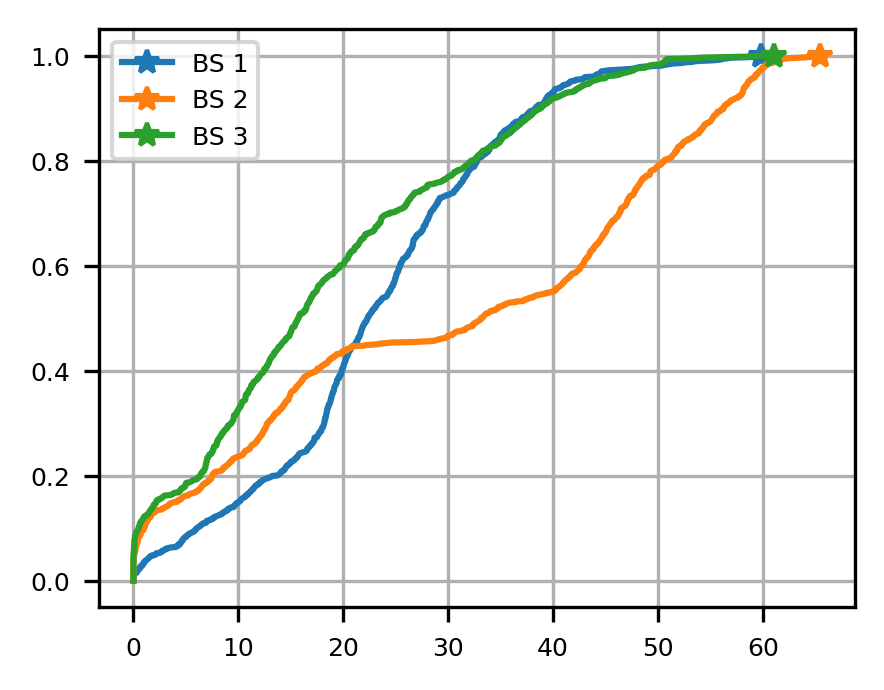

In [ ]:
pathgain = 6

channels_all = spare_generate_channels(scene, cm, dataset_size=1000, batch_size=80, T=1, K=20)*(10**pathgain)

all_se = get_svd_rate(channels_all[..., 0, 0])
for i in range(3):
    cdf_plot(all_se[:, i], label=f"BS {i+1}")
plt.legend()
plt.grid()
# plt.xlim([0, 40])
plt.show()

In [ ]:
n_samples = 2000
beamspace_set, channel_set, SVD_rate_set, scaler_set = spare_peel_channels(channels_all, dataset_size=n_samples, T=1, K=20)

filestring = path+f'eval_{pathgain}pg_scene_{scene_id}_{n_samples}_inputs_outputs_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

print(f"Saving to {filestring}")
with open(filestring, "wb") as f:
    pickle.dump([beamspace_set, channel_set, SVD_rate_set, scaler_set], f)

/tmp/ipykernel_92131/2036169806.py:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_92131/2036169806.py:76: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



completed 1/2000
completed 101/2000
completed 201/2000
completed 301/2000
completed 401/2000
completed 501/2000
completed 601/2000
completed 701/2000
completed 801/2000
completed 901/2000
completed 1001/2000
completed 1101/2000
completed 1201/2000
completed 1301/2000
completed 1401/2000
completed 1501/2000
completed 1601/2000
completed 1701/2000
completed 1801/2000
completed 1901/2000
Saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/eval_6pg_scene_B_2000_inputs_outputs_16_16_16_16_16.pickle


Channels for UEs 0-200 out of 1000
Channels for UEs 200-400 out of 1000
Channels for UEs 400-600 out of 1000
Channels for UEs 600-800 out of 1000
Channels for UEs 800-1000 out of 1000
[75, 231, 305, 424, 526, 554, 655, 674, 677, 902, 941]
Redoing 11 missed UEs
Still missed 1 UEs


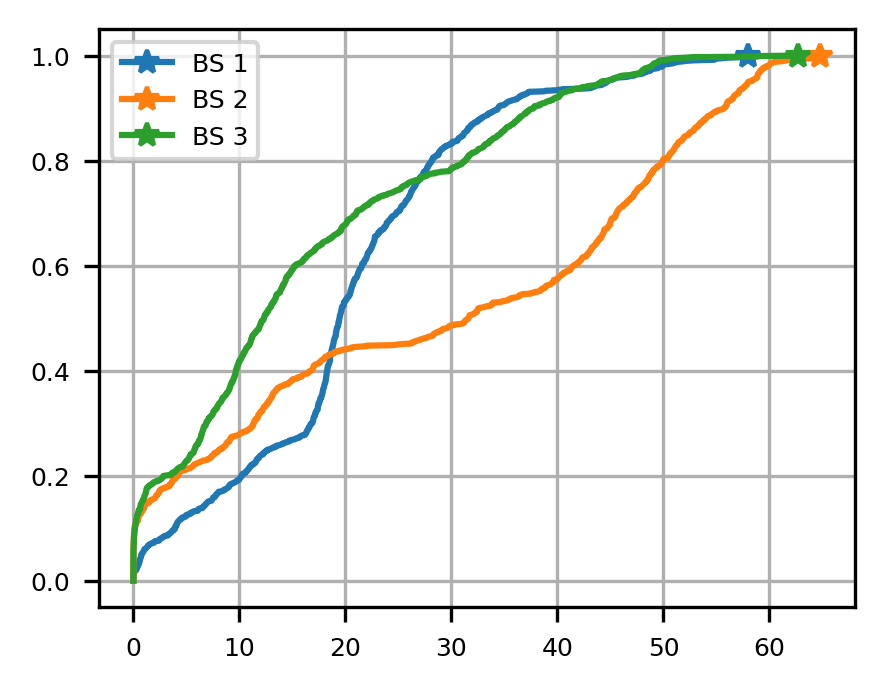

In [ ]:
pathgain = 6

channels_all = generate_channels(scene, cm, batch_size=200, dataset_size=1000)*10**pathgain

all_se = get_svd_rate(channels_all)
for i in range(3):
    cdf_plot(all_se[:, i], label=f"BS {i+1}")
plt.legend()
plt.grid()
# plt.xlim([0, 40])
plt.show()

In [ ]:
# check that log2det(I + HH*) = sumlog2(1+ sigma^2)
Ha = channels_all[:5]
Ha.shape # [U, C Nr, Nt]
print(np.log2(abs(np.linalg.det(np.eye(Nr) + Ha[0, 0] @ Ha[0, 0].conj().T))))
S = np.linalg.svd(Ha[0, 0], compute_uv=False)
print(np.sum(np.log2(1+S**2)))

47.94631248207934
47.946312482079364


In [ ]:
n_samples = 5000
beamspace_set, channel_set, SVD_rate_set, scaler_set = peel_channels(channels_all, dataset_size=n_samples)

filestring = path+f'{pathgain}pg_scene_{scene_id}_{n_samples}_inputs_outputs_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

print(f"Saving to {filestring}")
with open(filestring, "wb") as f:
    pickle.dump([beamspace_set, channel_set, SVD_rate_set, scaler_set], f)

/tmp/ipykernel_123021/2868326460.py:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_123021/2868326460.py:76: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



completed 1/5000
completed 251/5000
completed 501/5000
completed 751/5000
completed 1001/5000
completed 1251/5000
completed 1501/5000
completed 1751/5000
completed 2001/5000
completed 2251/5000
completed 2501/5000
completed 2751/5000
completed 3001/5000
completed 3251/5000
completed 3501/5000
completed 3751/5000
completed 4001/5000
completed 4251/5000
completed 4501/5000
completed 4751/5000
Saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/6pg_scene_B_5000_inputs_outputs_16_16_16_16_16.pickle


In [ ]:
n_samples = 20_000
beamspace_set, channel_set, SVD_rate_set, scaler_set = peel_channels(channels_all, dataset_size=n_samples)

filestring = path+f'{pathgain}pg_scene_{scene_id}_{n_samples}_inputs_outputs_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'

print(f"Saving to {filestring}")
with open(filestring, "wb") as f:
    pickle.dump([beamspace_set, channel_set, SVD_rate_set, scaler_set], f)

/tmp/ipykernel_123021/2868326460.py:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_123021/2868326460.py:76: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



completed 1/20000
completed 1001/20000
completed 2001/20000
completed 3001/20000
completed 4001/20000
completed 5001/20000
completed 6001/20000
completed 7001/20000
completed 8001/20000
completed 9001/20000
completed 10001/20000
completed 11001/20000
completed 12001/20000
completed 13001/20000
completed 14001/20000
completed 15001/20000
completed 16001/20000
completed 17001/20000
completed 18001/20000
completed 19001/20000
Saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/6pg_scene_B_20000_inputs_outputs_16_16_16_16_16.pickle


In [ ]:
beamspace_set.shape, channel_set.shape

((25000, 17, 17, 96), (25000, 3, 20, 4, 64))

### Data loading

In [ ]:
if Lmax <31:
    n_samples = 25_000
else:
    n_samples = 20_000
pathgain = 6
scene_id = 'A'

filestring = path+f'{pathgain}pg_scene_{scene_id}_{n_samples}_inputs_outputs_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"Loading {filestring}")
with open(filestring, "rb") as f:
    beamspace_set, channel_set, SVD_rate_set, scaler_set = pickle.load(f)

Loading /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/6pg_scene_A_25000_inputs_outputs_16_16_16_16_16.pickle


In [ ]:
AUTO = tf.data.AUTOTUNE
batch_size = 64

train_index = int(n_samples * 0.8)

def make_tfds(beamspaces, channels, svd_pows, total_samples=1_000_000, batch_size=batch_size):
    # converts into a tfds for fast loading. If total_samples < len() then the datasets
    # are decreased in size up to total_samples
    in_beamspaces = tf.data.Dataset.from_tensor_slices(beamspaces[:total_samples])
    in_channels = tf.data.Dataset.from_tensor_slices(channels[:total_samples])
    out_svd_pows = tf.data.Dataset.from_tensor_slices(svd_pows[:total_samples])
    ds = tf.data.Dataset.zip((in_beamspaces, in_channels, out_svd_pows)).prefetch(AUTO).batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)
    return ds

train_ds = make_tfds(beamspace_set[:train_index], channel_set[:train_index], SVD_rate_set[:train_index],)# total_samples=35_000)
test_ds = make_tfds(beamspace_set[train_index:], channel_set[train_index:], SVD_rate_set[train_index:],) #total_samples=5_000)

2024-02-15 18:14:22.432143: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 9830400000 exceeds 10% of free system memory.
2024-02-15 18:14:25.903042: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 9830400000 exceeds 10% of free system memory.


In [ ]:
del beamspace_set, channel_set, SVD_rate_set
gc.collect()

0

## Deep Learning Model

In [ ]:
def map_fn2(fn, elems, fn_output_signature):
    batch_size = tf.shape(tf.nest.flatten(elems)[0])[0]
    arr = tf.TensorArray(
        tf.complex64, size=batch_size, element_shape=fn_output_signature.shape)
    for i in tf.range(batch_size):
        arr = arr.write(i, fn(tf.nest.map_structure(lambda x: x[i], elems)))
    return arr.stack()


@tf.function()
def sel_csi_num(SSBRI, Ncsi=32, Lmax=Lmax, N=8.0):
    # select the strongest n_cri number based on which beams are reported
    counts = tf.math.bincount(SSBRI, minlength=Lmax, maxlength=Lmax)
    # split allocation based on number selected relative to Lmax
    number_per_beam = tf.round(tf.cast(counts, tf.float32) / tf.reduce_max([tf.cast(tf.reduce_sum(counts), tf.float32), 1.0]) * Ncsi)
    number_per_beam = tf.clip_by_value(number_per_beam, 0.0, N)
    missed = tf.expand_dims(Ncsi - tf.reduce_sum(number_per_beam), axis=0)
    first_unmissed = tf.reshape(tf.argmin(number_per_beam), [1, 1])
    unmissed_val = tf.reduce_min(number_per_beam)
    if missed > 0:
        if missed > N:
            number_per_beam = tf.tensor_scatter_nd_add(number_per_beam, first_unmissed, [N])
            number_per_beam = tf.tensor_scatter_nd_add(number_per_beam, first_unmissed+1, missed-[N])
        else:
            number_per_beam = tf.tensor_scatter_nd_add(number_per_beam, first_unmissed, missed)
    if missed < 0:
        first_unmissed = tf.reshape(tf.argmax(number_per_beam), [1, 1])
        max_beams = tf.expand_dims(tf.reduce_max(number_per_beam), axis=0)
        if max_beams[0] < -1*missed[0]:
            missed = missed + max_beams
            number_per_beam = tf.tensor_scatter_nd_add(number_per_beam, first_unmissed, -1*max_beams)
            first_unmissed = tf.reshape(tf.argmax(number_per_beam), [1, 1])
        number_per_beam = tf.tensor_scatter_nd_add(number_per_beam, first_unmissed, missed)
    return tf.cast(number_per_beam, tf.int32)


# @tf.function() # can't use with map_fn due to unary lacking
def batch_c_iter_func(correlations, csi_codebook, b, m, c=0, Ncsi=16):
    # correlations is shape [Lmax, N] and sorted
    # b_inds is shape [U]
    m_c = tf.boolean_mask(m, (b==c))
    prop_selections = sel_csi_num(m_c, Lmax=Lmax, Ncsi=Ncsi, N=8) # [Lmax]
    csi_sub_c = tf.map_fn(lambda ell:doubletobatch((correlations[ell], prop_selections[ell], csi_codebook[ell])), tf.range(Lmax), fn_output_signature=tf.RaggedTensorSpec(ragged_rank=0, dtype=tf.complex64))
    csi_sub_c = tf.reshape(csi_sub_c, [Ncsi, -1, Nt])

    return csi_sub_c # [Ncsi, Bg, Nt]


# @tf.function() # can't use with map_fn due to unary lacking
def tobebatch(args):
    m, b, correlations, csi_codebook, Ncsi = args
    csi_sub_b = tf.map_fn(lambda c: batch_c_iter_func(correlations[c], csi_codebook[c], b, m, c=c, Ncsi=Ncsi), tf.range(3), fn_output_signature=tf.complex64)
    return csi_sub_b


@tf.function()
def doubletobatch(args):
    # passing in correlations of size [N], prop_selections[ell] scalar, csi_codebook [N, Bg, Nt], do the inside of ell for loop above
    correlations, prop_selection, csi_codebook = args
    indices = correlations[0:prop_selection]
    csi_codebook_ell = tf.gather(csi_codebook, indices, axis=0) # [propsel, Bg, Nt]
    return csi_codebook_ell


# @tf.function() # can't use with map_fn due to unary lacking
def tf_select_subset(ssb_codebook, csi_codebook, m, b, Ncsi=16): # m is [B, U]
    B, C, Lmax, N, bg, Nt = csi_codebook.shape
    correlations = tf.argsort(tf.reduce_max(tf.abs(tf.einsum('bclt,bclngt->bclng', ssb_codebook, tf.math.conj(csi_codebook))), axis=-1), axis=-1, direction='DESCENDING') # [B, C, Lmax, N] find which of the Lmax-N to use based on max over bg dimension
    csi_sub = tf.map_fn(lambda batch: tobebatch((m[batch], b[batch], correlations[batch], csi_codebook[batch], Ncsi)), tf.range(batch_size), fn_output_signature=tf.complex64)
    return csi_sub


@tf.function()
def tf_rsrp_rx_comb(H, beams): # potential issue of what about no users/users with 0 power
    # H is [?, C, U, Nr, Nt] and beams is [?, C, Lmax, Nt]
    B, C, U, Nr, Nt = H.shape
    B, C, Lmax, _ = beams.shape
    rsrps = tf.abs(tf.norm(tf.einsum('bcurt,bclt->bucrl', H, beams), axis=-2)) # * 20/Ktotal # [?, U, C, Lmax]
    flat_rsrps = tf.reshape(rsrps, [B, U, -1])
    phat = tf.reduce_max(flat_rsrps, axis=-1)
    beam_alloc = tf.argmax(flat_rsrps, axis=-1) # [B, U]
    # now figure out the conversion back to CxLmax indexing
    i1 = beam_alloc//Lmax
    i2 = beam_alloc - i1*Lmax
    bhat = tf.cast(i1, tf.int32)
    mhat = tf.cast(i2, tf.int32)
    # return rsrps, SSBRI, bs allocation
    return phat, mhat, bhat


@tf.function()
def select_bu(args):
    flat_rsrp, b_flat = args
    return flat_rsrp[b_flat]


@tf.function()
def tf_rsrp_rx_comb_csistep(H, beams, b):
    # same as above but don't allow changing b
    # b is shape [B, U]
    B, C, U, Nr, Nt = H.shape
    B, C, N, bg, _ = beams.shape
    rsrps = tf.abs(tf.norm(tf.einsum('bcurt,bclgt->buclrg', H, beams), axis=[-2, -1])) # * 20/Ktotal # [?, U, C, Lmax]
    rsrps_flat = tf.reshape(rsrps, [B*U, C, N])
    b_flat = tf.reshape(b, [-1])
    rsrps_bactive = tf.vectorized_map(select_bu, (rsrps_flat, b_flat))
    rsrps_bactive = tf.reshape(rsrps_bactive, [B, U, N])

    phat = tf.reduce_max(rsrps_bactive, axis=-1)
    mhat = tf.cast(tf.argmax(rsrps_bactive, axis=-1), tf.int32)
    # return rsrps, SSBRI, bs allocation
    return phat, mhat, b


@tf.function()
def tf_deconvert_beamspace(beamspace, Lmax=Lmax):
    # convert from beamspace to beamformers
    # y = tf.cast(tf.reshape(y, output_dim), dtype=tf.complex64)
    # y = y[..., :Lmax] + 1j*y[..., Lmax:]
    complex_beamspace = tf.cast(beamspace[..., :Lmax], tf.complex64) + 1j * tf.cast(beamspace[..., Lmax:], tf.complex64) # [?, Nx, Ny, Lmax]
    beams = tf.einsum('nx, bnycl->bxycl', tf_U_NxNx_inv, tf.einsum('yn,bxncl->bxycl', tf_U_NyNy_inv, complex_beamspace))
    beams = tf.reshape(tf.transpose(beams, [0, 3, 4, 1, 2]), [-1, C, Lmax, Nt])
    beams = beams / (tf.norm(beams, axis=-1, keepdims=True)+1e-8)
    return beams


@tf.function()
def tf_deconvert_beamspace_csi(beamspace, Lmax=Lmax, N=8, bg=4):
    # same as above but for CSI-RS with shape [B, Nx1, Ny1, bg, N, C, Lmax]
    complex_beamspace = tf.cast(beamspace[..., :Lmax], tf.complex64) + 1j * tf.cast(beamspace[..., Lmax:], tf.complex64) # [?, Nx, Ny, Lmax]
    beams = tf.einsum('nx, bnygscl->bxygscl', tf_U_NxNx_inv, tf.einsum('yn,bxngscl->bxygscl', tf_U_NyNy_inv, complex_beamspace)) # [?, Nx, Ny, Bg, N, C, Lmax]
    beams = tf.reshape(tf.transpose(beams, [0, 5, 6, 4, 3, 1, 2]), [-1, C, Lmax, N, bg, Nt]) # [B, C, Lmax, N, Bg, Nt]
    beams = beams / (tf.norm(beams, axis=-1, keepdims=True)+1e-8)
    return beams


@tf.function()
def extract_Hfi_batch(args):
    H, indices = args
    return tf.vectorized_map(extract_Hfi_bs, args)

@tf.function()
def extract_Hfi_bs(args):
    H, index = args # stripped B and U so index is singular
    return H[index]


@tf.function()
def tflog2(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(2, dtype=numerator.dtype))
  return numerator / denominator



tf_nr_eye = tf.eye(Nr, dtype=tf.complex64)
tf_nr_eye_U = tf.repeat(tf.reshape(tf.eye(Nr, dtype=tf.complex64), [1, Nr, Nr]), [20], axis=0)


# @tf.function()
def tf_se_sumimo(args):
    HFFH, bhat = args
    # just calculate for one batch and one user, then vectorize
    D = tf.gather(HFFH, bhat)
    infer = tf.reduce_sum(HFFH, axis=0)-D
    Cu = tflog2(tf.abs(tf.linalg.det(tf_nr_eye + tf.matmul(D, tf_pinv(tf_nr_eye+infer))))) #[U]
    return Cu


@tf.function()
def tf_se_mumimo_batch(args):
    HFFH, bhat = args
    D = tf.gather(HFFH, bhat, axis=1, batch_dims=1)
    infer = tf.reduce_sum(HFFH, axis=1)-D
    Cu = tflog2(tf.abs(tf.linalg.det(tf_nr_eye_U + tf.matmul(D, tf_pinv(tf_nr_eye_U+infer))))) #[U]
    return Cu


@tf.function()
def tf_se_mumimo(csi_sub, ihat, bhat, H):
    # get the mu-mimo achievable rate
    # first, get every combination of HuFciFc*Hu* for all c
    # csi_sub is [B, C, N, bg, Nt]
    # ihat is [B, U], bhat is [B, U]
    B, C, U, Nr, Nt = H.shape
    # For each user, get the effective beamformed channel in all cases
    beamformed_chan = tf.einsum('bcurt,bcngt->buncrg', H, csi_sub) # [B, U, Ncsi, C, Nr, Bg]
    # then select the relevant ones based on ihat
    Hfi = tf.transpose(tf.vectorized_map(extract_Hfi_batch, (beamformed_chan, ihat)), [0, 2, 1, 3, 4]) # [B, C, U, Nr, Bg]
    HFFH = tf.einsum('bcurg,bcung->bucrn', Hfi, tf.math.conj(Hfi)) #[B, U, C, Nr, Nr]
    BCu = tf.vectorized_map(tf_se_mumimo_batch, (HFFH, bhat))
    return BCu


@tf.function()
def select_svd_rate(SVD_rates, b):
    # Given rates of [B, C, U] and b of [B, U] select the corresponding ones
    SVD_rates = tf.transpose(SVD_rates, [0, 2, 1])
    svd_sel_rates = tf.vectorized_map(sel_svd_batch, (SVD_rates, b))
    return svd_sel_rates


@tf.function()
def sel_svd_batch(args):
    return tf.vectorized_map(sel_svd_batch_u, args)


@tf.function()
def sel_svd_batch_u(args):
    svd_rates, b = args
    return svd_rates[b]


@tf.function()
def tf_rate_loss(SEtrue, SEhat):
    se_true_filter = SEtrue > 1e-3
    return tf.reduce_mean(tf.boolean_mask(SEtrue-SEhat, se_true_filter))


@tf.function()
def beam_loss(RSRP, svd_pow):
    # print(f"Comparison")
    # print(tf_10log10(RSRP))
    # print(tf_10log10(svd_pow))
    return tf.reduce_mean(tf_10log10(svd_pow) - tf_10log10(RSRP)) # /svd_pow some svd_pow is 0...


@tf.function()
def unsup_loss(rsrp):
    return -tf.reduce_mean(tf_10log10(rsrp))


@tf.function()
def tf_beamspace2loss(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # one function to get all the way to the loss calculation
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    svd_pow = tf_get_svd_pow(H)
    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    loss = beam_loss(rsrp, svd_pow)
    return loss


@tf.function()
def unsup_tf_beamspace2loss(Hest, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    Hest = my_tf_const_mod(Hest, bits=2)
    rsrp, ssbri = tf_rsrp_rx_comb(Hest, beams)
    loss = unsup_loss(rsrp)
    return loss


@tf.function()
def tf_get_svd_pow(channels):
    # channels is of size [?, U, Nr, Nt]
    Su = tf.linalg.svd(channels, compute_uv=False) # * 20/Ktotal
    return Su[:, :, 0]


@tf.function()
def tf_hybrid(beamformers, Nb=b_phaseshifter):
    # beamformers is shape [?, Lmax, Nt], round to Nb bit phase shifts
    quant_beamformers = tf.grad_pass_through(my_tf_round)(beamformers)
    return quant_beamformers


def my_tf_round(x, bits=b_phaseshifter):
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    return tf.cast(tf.round(tf.math.real(x) * multiplier) / multiplier, dtype=ctype) + 1j * tf.cast(tf.round(tf.math.imag(x) * multiplier) / multiplier, dtype=ctype)


@tf.function()
def my_tf_const_mod(x, bits=b_phaseshifter):
    # previous was not constant modulus
    phases = tf.math.angle(x)
    phases = (phases - pi) / (2*pi)
    amplitudes = tf.abs(x)
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    quant_phases = tf.cast(tf.round(phases * multiplier) / multiplier, dtype=ctype)
    quant_phases = quant_phases * 2 * pi - pi
    x_quant = tf.exp(1j * quant_phases)
    x_quant = x_quant / tf.norm(x_quant, axis=-1, keepdims=True)
    return x_quant


@tf.function()
def tf_pinv(a, rcond=None):
    # need psuedo inverse that supports complex numbers with tf. 
    # Referenced from https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/ops/linalg/linalg_impl.py
    dtype = a.dtype.as_numpy_dtype

    if rcond is None:
        def get_dim_size(dim):
            dim_val = a.shape[dim]
            if dim_val is not None:
                return dim_val
            return tf.shape(a)[dim]

        num_rows = get_dim_size(-2)
        num_cols = get_dim_size(-1)
        if isinstance(num_rows, int) and isinstance(num_cols, int):
            max_rows_cols = float(max(num_rows, num_cols))
        else:
            max_rows_cols = tf.cast(tf.maximum(num_rows, num_cols), dtype)
        rcond = 10. * max_rows_cols * np.finfo(dtype).eps

    rcond = tf.convert_to_tensor(rcond, dtype=dtype, name='rcond')

    # Calculate pseudo inverse via SVD.
    # Note: if a is Hermitian then u == v. (We might observe additional
    # performance by explicitly setting `v = u` in such cases.)
    [
        singular_values,  # Sigma
        left_singular_vectors,  # U
        right_singular_vectors,  # V
    ] = tf.linalg.svd(
        a, full_matrices=False, compute_uv=True)

    # Saturate small singular values to inf. This has the effect of make
    # `1. / s = 0.` while not resulting in `NaN` gradients.
    cutoff = tf.cast(rcond, dtype=singular_values.dtype) * tf.reduce_max(singular_values, axis=-1)
    singular_values = tf.where(
        singular_values > cutoff[..., None], singular_values,
        np.array(np.inf, dtype))

    # By the definition of the SVD, `a == u @ s @ v^H`, and the pseudo-inverse
    # is defined as `pinv(a) == v @ inv(s) @ u^H`.
    a_pinv = tf.matmul(
        right_singular_vectors / tf.cast(singular_values[..., None, :], dtype=dtype),
        left_singular_vectors,
        adjoint_b=True)

    if a.shape is not None and a.shape.rank is not None:
      a_pinv.set_shape(a.shape[:-2].concatenate([a.shape[-1], a.shape[-2]]))

    return a_pinv

Processing goes:

1.   Get Obsc
2.   feed into NN to get Fhat_ssb and Fhat_csi
3.   Get mhat, phat, bhat from Fhat_ssb
4.   Select Fsub using max-matrix-vector correlation of Fhat_ssb and Fhat_csi
    *   Essentially calculate max_j <Fhat_ssb, Fhat_csi>
    *   Take the most correlated options based on how many users report in each SSB
    *   If more beams than users exist, just randomly select a beam.
    *   If less beams than users exist, take the highest power based on phat with one per mhat.
5.   Get ihat from Fsub and calculate SE equation
6.   Get SE from labels Y_bhat
7.   Calculate MAE to avoid high loss as a result of very good channels. Dont want to penalize more for getting |40-30| than |20-10|. In fact, we probably want to penalize less. Maybe something like |Y - Yhat| / |Y|.





In [ ]:
part_conv = partial(keras.layers.SeparableConv2D, kernel_size=(5, 5), activation='relu', padding='same', depth_multiplier=1)
part_inv_conv = partial(keras.layers.Conv2DTranspose, kernel_size=(5, 5), strides=2, padding='same', activation='relu')
dtype_con ='float32'

def get_ssb_network(Lmax=Lmax, output_dim=[batch_size, Nx1, Ny1, C, Lmax*2], input_dim=[Nx1+1, Ny1+1, C*2*Lmax], depth=3):
    inputs = keras.Input(input_dim)
    x = keras.layers.BatchNormalization()(inputs)
    x = part_conv(filters=128, padding='valid', kernel_size=2)(x)
    for i in range(depth):
        x = part_conv(filters=128)(x)
        x = keras.layers.MaxPool2D(padding='same')(x)
    for i in range(depth):
        x = part_inv_conv(filters=128)(x)

    y = part_conv(filters=np.prod(output_dim[3:]))(x)
    y = tf.reshape(y, output_dim)
    # y = tf.cast(tf.reshape(y, output_dim), dtype=tf.complex64)
    # y = y[..., :Lmax] + 1j*y[..., Lmax:]
    model = keras.Model(inputs, y)
    print(model.summary())
    return model

def get_csi_network(Lmax=Lmax, bg=4, depth=3, N=8):
    return get_ssb_network(Lmax, output_dim=[batch_size, Nx1, Ny1, bg, N, C, Lmax*2], depth=depth)



class XBM(keras.Model):
    """ Class to overload the training and prediction methods for the XBM """
    def __init__(self, ssb_network=None, csi_network=None, scalers=None, bg=4, N=8, Nx=Nx, Ny=Ny, depth=3, Ncsi=16):
        super().__init__()
        if ssb_network is None:
            self.ssb_network = get_ssb_network(depth=depth)
        else:
            self.ssb_network = ssb_network
        if csi_network is None:
            self.csi_network = get_csi_network(bg=bg, N=N, depth=depth)
        else:
            self.csi_network = csi_network
        self.scalers = scalers
        self.csi_per_ssb = N
        self.Nx = Nx
        self.Ny = Ny
        self.N = N
        self.Ncsi = Ncsi
        self.bg = bg

    def compile(self, optimizer, loss_func=None, **kwargs):
        super().compile(kwargs)
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.loss = keras.metrics.Mean(name="mean loss")
        self.ssb_rsrp = keras.metrics.Mean(name="RSRP")

        self.ssb_network.compile(self.optimizer, loss=keras.losses.MAE)
        self.csi_network.compile(self.optimizer, loss=keras.losses.MAE)

    def train_step(self, inputs):
        # unpack inputs
        (beamspace, channel_set, SVD_rates) = inputs

        # loss calculation and gradients
        with tf.GradientTape() as tape:
            pred_beamspace = self.ssb_network(beamspace)
            csi_beamspace = self.csi_network(beamspace)
            ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax) # [B, C, Lmax, Nt]
            p, m, b = tf_rsrp_rx_comb(channel_set, ssb_codebook)
            csi_codebook = tf_deconvert_beamspace_csi(csi_beamspace, Lmax=Lmax, N=self.csi_per_ssb, bg=self.bg)  # [B, C, ]
            # csi_codebook = tf.reshape(csi_codebook, [C, self.N, self.bg, Lmax, self.Nx*self.Ny])
            csi_sub = tf_select_subset(ssb_codebook, csi_codebook, m, b, self.Ncsi)
            p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_set, csi_sub, b)
            SEhat = tf_se_mumimo(csi_sub, ihat, b, channel_set)
            SEtrue = select_svd_rate(SVD_rates, b)
            loss = tf_rate_loss(SEtrue, SEhat)

        ssb_variables = self.ssb_network.trainable_variables
        csi_variables = self.csi_network.trainable_variables
        grads = tape.gradient(loss, ssb_variables+csi_variables)
        opt.apply_gradients(zip(grads, ssb_variables+csi_variables))
        self.loss.update_state(loss)
        self.ssb_rsrp.update_state(tf.reduce_mean(p))
        return {"SE_loss" : self.loss.result()}

    def test_step(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        ssb_loss = tf_beamspace2loss(channel_set, pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)

        csi_beamspace = self.csi_network(beamspace)
        csi_loss = tf_beamspace2loss(channel_set, csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)

        self.ssb_loss.update_state(ssb_loss)
        self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def predict(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        csi_beamspace = self.csi_network(beamspace)
        return pred_beamspace, csi_beamspace

In [ ]:
train_card = train_ds.cardinality().numpy()
test_card = test_ds.cardinality().numpy()

@tf.function()
def train_step1(beamspace, channel_set):
    with tf.GradientTape() as tape2:
        pred_beamspace = xbm.ssb_network(beamspace)
        ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax)
        p, m, b = tf_rsrp_rx_comb(channel_set, ssb_codebook)
        ssb_loss = -1*tf.reduce_mean(p)
    ssb_variables = xbm.ssb_network.trainable_variables
    grads = tape2.gradient(ssb_loss, ssb_variables)
    opt1.apply_gradients(zip(grads, ssb_variables))
    return ssb_codebook, m, b, ssb_loss

@tf.function()
def train_step2(beamspace):
    # with tf.GradientTape() as tape:
    csi_beamspace = xbm.csi_network(beamspace)
    csi_codebook = tf_deconvert_beamspace_csi(csi_beamspace, Lmax=Lmax, N=8, bg=4)
    return csi_codebook


@tf.function()
def train_step3(csi_sub, channel_set, SVD_rates, b):
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_set, csi_sub, b)
    SEhat = tf_se_mumimo(csi_sub, ihat, b, channel_set)
    SEtrue = select_svd_rate(SVD_rates, b)
    loss = tf_rate_loss(SEtrue, SEhat)
    return loss


def total_train_step(beamspace, channel_set, SVD_rates, Ncsi=16):
    ssb_codebook, m, b, ssb_loss = train_step1(beamspace, channel_set)
    with tf.GradientTape() as tape:
        csi_codebook = train_step2(beamspace)
        csi_sub = tf_select_subset(ssb_codebook, csi_codebook, m, b, Ncsi) # can't be in tf.function loop
        csi_loss = train_step3(csi_sub, channel_set, SVD_rates, b)
    csi_variables = xbm.csi_network.trainable_variables
    if tf.math.reduce_any(tf.math.is_inf(csi_loss)):
        return ssb_loss, -1
    else:
        grads = tape.gradient(csi_loss, csi_variables)
        opt2.apply_gradients(zip(grads, csi_variables))
    return ssb_loss, csi_loss



@tf.function()
def val_step(beamspace, channel_set, SVD_rates, Ncsi=16):
    pred_beamspace = xbm.ssb_network(beamspace)
    ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax)
    p, m, b = tf_rsrp_rx_comb(channel_set, ssb_codebook)
    ssb_loss = -1*tf.reduce_mean(p)
    csi_beamspace = xbm.csi_network(beamspace)
    csi_codebook = tf_deconvert_beamspace_csi(csi_beamspace, Lmax=Lmax, N=8, bg=4)
    csi_sub = tf_select_subset(ssb_codebook, csi_codebook, m, b, Ncsi)
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_set, csi_sub, b)
    SEhat = tf_se_mumimo(csi_sub, ihat, b, channel_set)
    SEtrue = select_svd_rate(SVD_rates, b)
    csi_loss = tf_rate_loss(SEtrue, SEhat)
    return ssb_loss, csi_loss


def total_val(Ncsi=16):
    csi_errors = np.zeros((test_card,))
    ssb_errors = np.zeros((test_card,))
    for i, vds in enumerate(test_ds):
        # (beamspace, channel_set, SVD_rates) = vds
        ssb_errors[i], csi_errors[i] = val_step(vds[0], vds[1], vds[2], Ncsi)
    return np.mean(ssb_errors), np.mean(csi_errors)


def multi_iter_training(n_iter=1, n_batch=train_card, Ncsi=16):
    csi_errors = np.zeros((n_iter,))
    ssb_errors = np.zeros((n_iter,))
    errors_sub1 = np.zeros((n_batch,))
    errors_sub2 = np.zeros((n_batch,))
    test_ssb_loss = np.zeros((n_batch,))
    test_csi_loss = np.zeros((n_batch,))

    for i in range(n_iter):
        for j, vds in enumerate(train_ds.take(n_batch)):
            ssb_loss, csi_loss = total_train_step(vds[0], vds[1], vds[2], Ncsi)
            errors_sub1[j] = ssb_loss
            errors_sub2[j] = csi_loss
            if not j%20:
                print(f"batch {j+1}/{n_batch}")
        ssb_errors[i] = np.mean(errors_sub1)
        csi_errors[i] = np.mean(errors_sub2)
        print(f"finished {i+1}/{n_iter} mean csi_error {csi_errors[i]:.2f} mean ssb error {ssb_errors[i]:.2f}")
        test_ssb_loss[i], test_csi_loss[i] = total_val(Ncsi)
        print(f"test csi_error {test_csi_loss[i]:.2f} test ssb error {test_ssb_loss[i]:.2f} ")

NameError: name 'train_ds' is not defined

In [ ]:
xbm = XBM()
opt1 = keras.optimizers.Adam(learning_rate=4e-4)
opt2 = keras.optimizers.Adam(learning_rate=2e-4)
ssb_variables = xbm.ssb_network.trainable_variables
csi_variables = xbm.csi_network.trainable_variables
opt1.build(ssb_variables)
opt2.build(csi_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17, 17, 96)]      0         
                                                                 
 batch_normalization (BatchN  (None, 17, 17, 96)       384       
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 16, 16, 128)      12800     
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 16, 16, 128)      19712     
 leConv2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 128)        0         
 )                                                           

In [ ]:
scene_id = 'A'
n_samples = 25_000

xbm = XBM()
opt1 = keras.optimizers.Adam(learning_rate=4e-4)
opt2 = keras.optimizers.Adam(learning_rate=2e-4)

if Lmax == 32:
    cpk = 1
else:
    cpk = 1

# Nx = 8
# Ny = 8

cpk_path = path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-{cpk}-1'
checkpoint = tf.train.Checkpoint(optimizer=opt1, model=xbm.ssb_network)
stat1 = checkpoint.restore(cpk_path)

cpk_path = path + f'models/scene_{scene_id}_{n_samples}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-{cpk}-1'
checkpoint = tf.train.Checkpoint(optimizer=opt2, model=xbm.csi_network)
stat2 = checkpoint.restore(cpk_path)

Nx = 16
Ny = 16
# total_val()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 17, 17, 96)]      0         
                                                                 
 batch_normalization_2 (Batc  (None, 17, 17, 96)       384       
 hNormalization)                                                 
                                                                 
 separable_conv2d_10 (Separa  (None, 16, 16, 128)      12800     
 bleConv2D)                                                      
                                                                 
 separable_conv2d_11 (Separa  (None, 16, 16, 128)      19712     
 bleConv2D)                                                      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                       

In [ ]:
ssb_net = keras.models.load_model(path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
csi_net = keras.models.load_model(path + f'models/scene_{scene_id}_{n_samples}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')

with open(path + f'models/optimizers_scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle', 'rb') as f:
    opt1, op2t = pickle.load(f)

xbm = XBM(ssb_network=ssb_net, csi_network=csi_net)


ssb_variables = xbm.ssb_network.trainable_variables
csi_variables = xbm.csi_network.trainable_variables
# opt1.build(ssb_variables)
# opt2.build(csi_variables)



In [ ]:
for i in range(10):
    multi_iter_training(1)
    checkpoint1 = tf.train.Checkpoint(model=xbm.ssb_network,optim=opt1)
    checkpoint2 = tf.train.Checkpoint(model=xbm.csi_network,optim=opt2)
    print(f"saving to", path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-{i+2}')
    checkpoint1.save(path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-{i+2}')
    checkpoint2.save(path + f'models/scene_{scene_id}_{n_samples}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-{i+2}')

2024-02-14 23:10:58.855210: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320000 exceeds 10% of free system memory.


batch 1/500
batch 21/500
batch 41/500
batch 61/500
batch 81/500
batch 101/500
batch 121/500
batch 141/500
batch 161/500
batch 181/500
batch 201/500
batch 221/500
batch 241/500
batch 261/500
batch 281/500
batch 301/500
batch 321/500
batch 341/500
batch 361/500
batch 381/500
batch 401/500
batch 421/500
batch 441/500
batch 461/500
batch 481/500
finished 1/1 mean csi_error 4.28 mean ssb error -109.60
test csi_error 4.28 test ssb error -110.29 
saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/models/scene_A_20000_ssb_16_16_16_16_32/ckpt-2


2024-02-15 00:18:07.108625: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320000 exceeds 10% of free system memory.


batch 1/500
batch 21/500
batch 41/500
batch 61/500
batch 81/500
batch 101/500
batch 121/500
batch 141/500
batch 161/500
batch 181/500
batch 201/500
batch 221/500
batch 241/500
batch 261/500
batch 281/500
batch 301/500
batch 321/500
batch 341/500
batch 361/500
batch 381/500
batch 401/500
batch 421/500
batch 441/500
batch 461/500
batch 481/500
finished 1/1 mean csi_error 4.15 mean ssb error -109.82
test csi_error 4.21 test ssb error -110.43 
saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/models/scene_A_20000_ssb_16_16_16_16_32/ckpt-3


2024-02-15 01:25:21.905822: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320000 exceeds 10% of free system memory.


batch 1/500
batch 21/500
batch 41/500
batch 61/500
batch 81/500
batch 101/500
batch 121/500
batch 141/500
batch 161/500
batch 181/500
batch 201/500
batch 221/500
batch 241/500
batch 261/500
batch 281/500
batch 301/500
batch 321/500
batch 341/500
batch 361/500
batch 381/500
batch 401/500
batch 421/500
batch 441/500
batch 461/500
batch 481/500
finished 1/1 mean csi_error 4.09 mean ssb error -110.17
test csi_error 4.27 test ssb error -111.02 
saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/models/scene_A_20000_ssb_16_16_16_16_32/ckpt-4
batch 1/500
batch 21/500
batch 41/500
batch 61/500
batch 81/500
batch 101/500
batch 121/500
batch 141/500
batch 161/500
batch 181/500
batch 201/500
batch 221/500
batch 241/500
batch 261/500
batch 281/500
batch 301/500
batch 321/500
batch 341/500
batch 361/500
batch 381/500
batch 401/500
batch 421/500
batch 441/500
batch 461/500
batch 481/500
finished 1/1 mean csi_error 3.54 mean ssb error -110.63
test csi_error 4.13 test ssb error -111.30 
sa

KeyboardInterrupt: 

In [ ]:
multi_iter_training(1) # 8x8 arrays

2024-02-15 09:22:51.093479: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7864320000 exceeds 10% of free system memory.


batch 1/500
batch 21/500
batch 41/500
batch 61/500
batch 81/500
batch 101/500
batch 121/500
batch 141/500
batch 161/500
batch 181/500
batch 201/500
batch 221/500
batch 241/500
batch 261/500
batch 281/500
batch 301/500
batch 321/500
batch 341/500
batch 361/500
batch 381/500
batch 401/500
batch 421/500
batch 441/500
batch 461/500
batch 481/500
finished 1/1 mean csi_error 3.25 mean ssb error -111.13
test csi_error 4.00 test ssb error -111.82 


In [ ]:
print(total_val())

(-111.81778302001953, 4.003895029067993)


In [ ]:
# os.mkdir(path+'models/5000/')
# model_dir = path+f'models/{n_samples}/model1'
print(f"saving to {path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras'}")

xbm.ssb_network.save(path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')
xbm.csi_network.save(path + f'models/scene_{scene_id}_{n_samples}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.keras')

print(total_val())

saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/models/scene_A_20000_ssb_16_16_16_16_32.keras
(-111.81778302001953, 4.00389471244812)


In [ ]:
checkpoint1 = tf.train.Checkpoint(model=xbm.ssb_network,optim=opt1)
checkpoint2 = tf.train.Checkpoint(model=xbm.csi_network,optim=opt2)

checkpoint1.save(path + f'models/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-1')
checkpoint2.save(path + f'models/scene_{scene_id}_{n_samples}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}/ckpt-1')

'/media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/models/scene_A_20000_csi_16_16_16_16_32/ckpt-1-1'

In [ ]:
gc.collect()

8855

## Evaluation

In [ ]:
# ECDF of the SSB RSRP
# first get the model SSB RSRP
@tf.function()
def val_ssb_step(beamspace, channel_set):
    pred_beamspace = xbm.ssb_network(beamspace)
    ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax)
    p, m, b = tf_rsrp_rx_comb(channel_set, ssb_codebook)
    return p, m, b


class DFT_method():
    def __init__(self, Nx=Nx, Ny=Ny, Lmax=Lmax, csi_per_ssb=4):
        self.Nx = Nx
        self.Ny = Ny
        self.Lmax = Lmax
        self.csi_per_ssb = csi_per_ssb

        self.SSB_codebook = DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny, OH=2, OV=2).transpose(2, 0, 1)
        self.CSI_codebook = DFT_codebook(n_beams=Lmax*csi_per_ssb, Nx=Nx, Ny=Ny, OH=csi_per_ssb, OV=csi_per_ssb).transpose(2, 0, 1)

    def predict(self, *args):
        return self.SSB_codebook, self.CSI_codebook


dft_algo = DFT_method()

dft_ssb_codebook = np.tile(dft_algo.SSB_codebook.reshape(1, 1, Lmax, Nt), [batch_size, C, 1, 1]) / np.sqrt(Nt)
single_codebook = np.zeros_like(dft_ssb_codebook)
single_codebook[:, :, :, 0] = 1


def test_ssb():
    ssb_rsrp = np.zeros((test_card, batch_size, 20))
    m_algo = np.zeros((test_card, batch_size, 20))
    b_algo = np.zeros((test_card, batch_size, 20))

    dft_ssb = np.zeros((test_card, batch_size, 20))
    m_dft = np.zeros((test_card, batch_size, 20))
    b_dft = np.zeros((test_card, batch_size, 20))

    single_ssb = np.zeros((test_card, batch_size, 20))
    m_single = np.zeros((test_card, batch_size, 20))
    b_single = np.zeros((test_card, batch_size, 20))
    for i, vds in enumerate(test_ds):
        # (beamspace, channel_set, SVD_rates) = vds
        ssb_rsrp[i], m_algo[i], b_algo[i] = val_ssb_step(vds[0], vds[1])
        dft_ssb[i], m_dft[i], b_dft[i] = tf_rsrp_rx_comb(vds[1], dft_ssb_codebook)
        single_ssb[i], m_single[i], b_single[i] = tf_rsrp_rx_comb(vds[1], single_codebook)
    return (ssb_rsrp, m_algo, b_algo), (dft_ssb, m_dft, b_dft), (single_ssb, m_single, b_single)

# algo_ssb, dft_ssb, single_ant = test_ssb()


def filter_on_rsrp(ssb_results):
    # filter out where no UE is/no power
    rsrp, m, b = ssb_results # [?, 20]
    rsrp, m, b = rsrp.flatten(), m.flatten(), b.flatten()
    active_set = rsrp > 0
    filt_rsrp = rsrp[active_set]
    filt_m = m[active_set]
    filt_b = b[active_set]
    return filt_rsrp, filt_m, filt_b


Generating codebook for 16 from size 16x16x2x2
Generating codebook for 64 from size 16x16x4x4


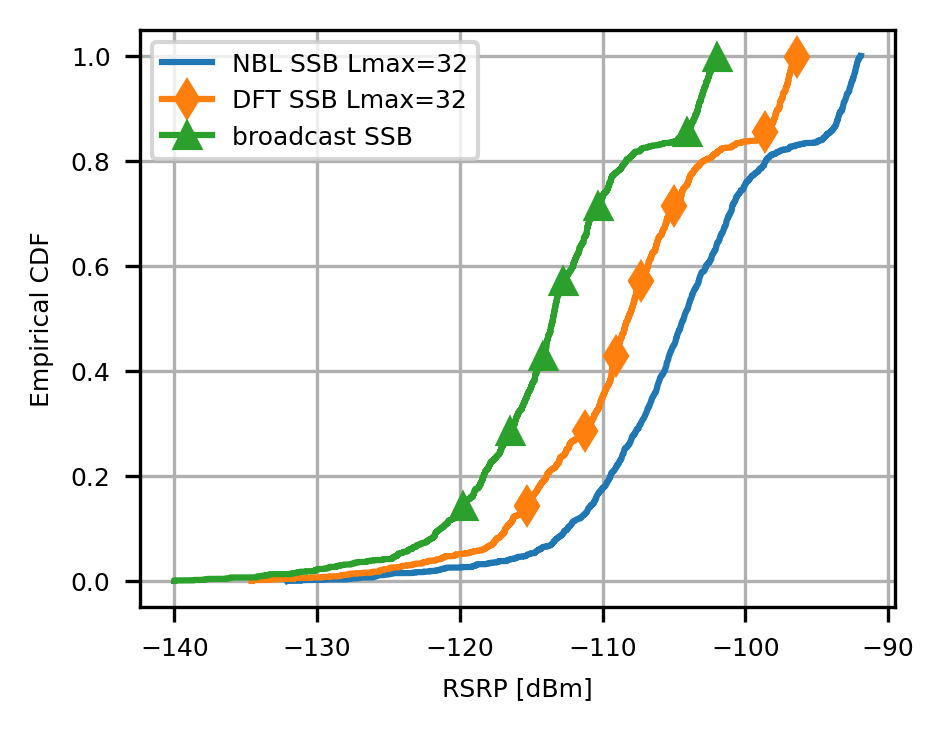

In [ ]:
algos = ["NBL ", "DFT ", "broadcast "]
markers = ["", "d", "^"]

ecdf = ECDF(logx(filt_rsrp/270*20))
plt.plot(ecdf.x, ecdf.y, markers[0]+"-", label=algos[0]+f"SSB Lmax={Lmax}", markevery=8000)

ecdf = ECDF(logx(dft_rsrp/270*20))
plt.plot(ecdf.x, ecdf.y, markers[1]+"-", label=algos[1]+f"SSB Lmax={Lmax}", markevery=8000)

ecdf = ECDF(logx(sing_rsrp/270*20))
plt.plot(ecdf.x, ecdf.y, markers[2]+"-", label=algos[2]+f"SSB", markevery=8000)

plt.legend()
plt.xlabel("RSRP [dBm]")
plt.ylabel("Empirical CDF")
plt.grid()
# plt.savefig(path+f"results/SSB_figure.pdf", bbox_inches='tight')

In [ ]:
filt_rsrp, filt_m, filt_b = filter_on_rsrp(algo_ssb)
dft_rsrp, dft_m, dft_b = filter_on_rsrp(dft_ssb)

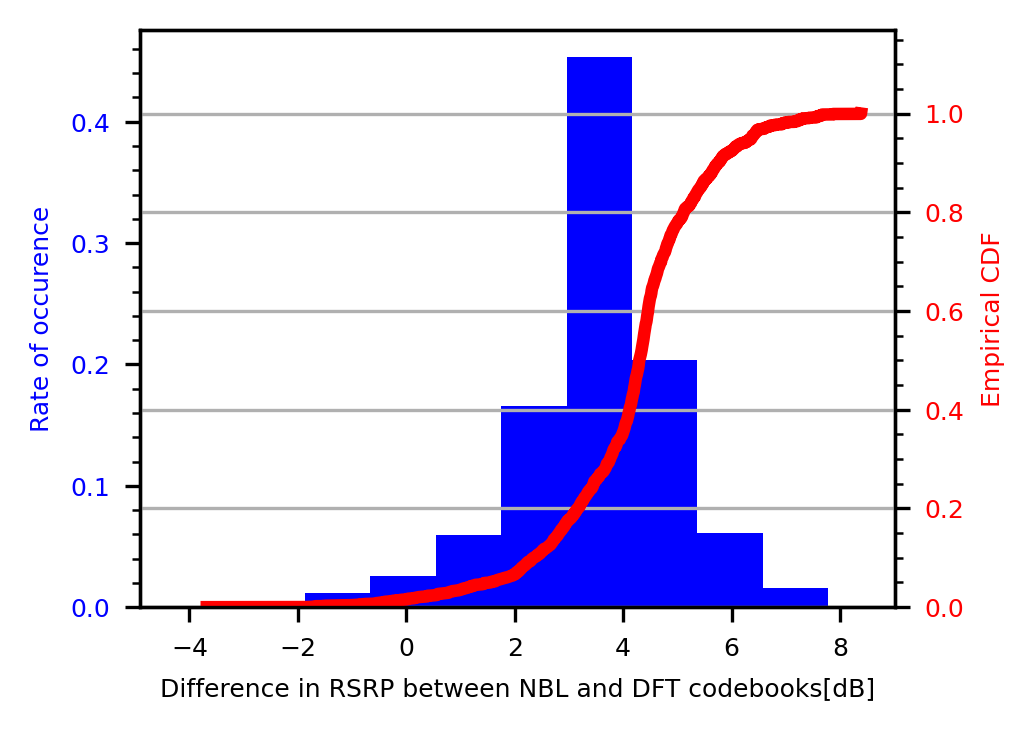

In [ ]:
# histogram of delta with DFT codebooks
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

delta = logx(filt_rsrp/270*20) - logx(dft_rsrp/270*20)
ecdf = ECDF(delta)
ax2.plot(ecdf.x, ecdf.y, 'r')

results, edges = np.histogram(delta, density=True)
binWidth = edges[1] - edges[0]
ax1.bar(edges[:-1], results*binWidth, binWidth, color='b')

# ax1.hist(delta, density=True, color='b')
ax1.set_xlabel("Difference in RSRP between NBL and DFT codebooks[dB]")
ax1.set_ylabel("Rate of occurence", color='b')
ax1.tick_params(axis="y", labelcolor='b')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
# ax1.set_ylim([0, 0.28])


ax2.set_ylabel("Empirical CDF", color='r')
ax2.tick_params(axis="y", labelcolor='r')
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(True, 'major')
ax2.set_ylim([0, 1.17])

plt.savefig(path+f"results/SSB_delta.pdf", bbox_inches='tight')

In [ ]:
NBL_assign, _ = np.histogram(filt_b, density=True, bins=3)
dft_assign, _ = np.histogram(dft_b, density=True, bins=3)
df = pd.DataFrame([NBL_assign/3*2, dft_assign/3*2], columns=["Cell 0", "Cell 1", "Cell 2"])
df

,Cell 0,Cell 1,Cell 2
0,0.468762,0.45651,0.074728
1,0.497731,0.42250,0.079769


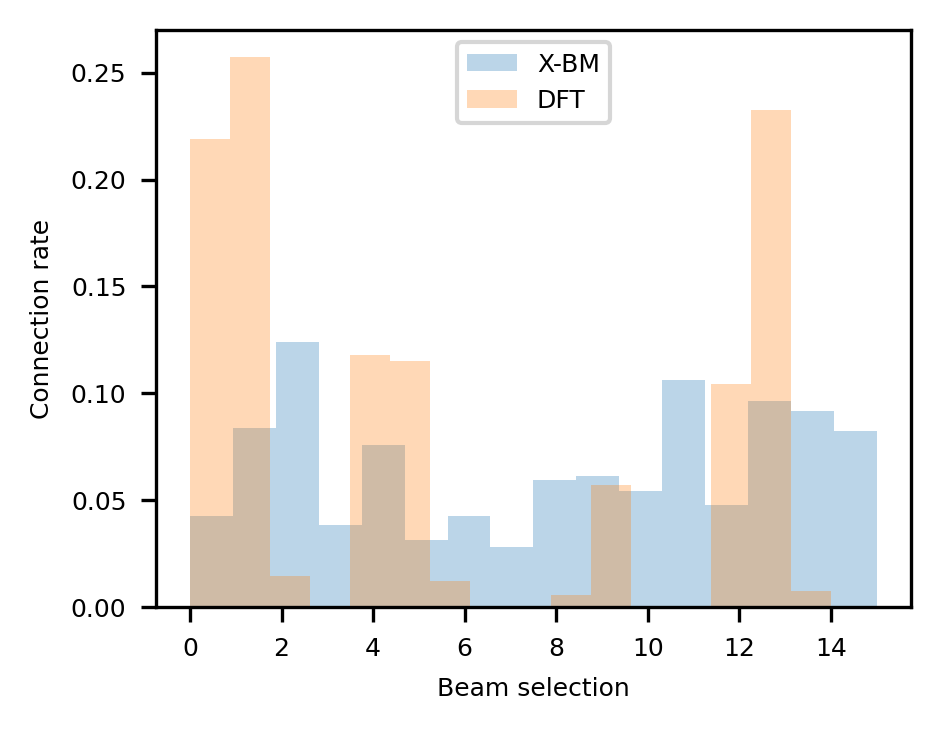

In [ ]:
plt.hist(filt_m, density=True, bins=16, alpha=0.3, label="X-BM")
plt.hist(dft_m, density=True, bins=16, alpha=0.3, label="DFT")
# plt.xticks([0, 1, 2])
plt.xlabel("Beam selection")
plt.ylabel("Connection rate")
plt.legend()

In [ ]:
ssb_saving_path = path + f'results/scene_{scene_id}_{n_samples}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"Saving to {ssb_saving_path}")

with open(ssb_saving_path, "wb") as f:
    pickle.dump([algo_ssb, dft_ssb, single_ant], f)

Saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_20000_ssb_16_16_16_16_32.pickle


In [ ]:
# CSI-RS effective SINR
# first, get CSI-RS results for S, SINR.
@tf.function()
def val_csi_step(beamspace, channel_set, SVD_rates, Ncsi=16):
    pred_beamspace = xbm.ssb_network(beamspace)
    ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax)
    p, m, b = tf_rsrp_rx_comb(channel_set, ssb_codebook)
    csi_beamspace = xbm.csi_network(beamspace)
    csi_codebook = tf_deconvert_beamspace_csi(csi_beamspace, Lmax=Lmax, N=8, bg=4)
    csi_sub = tf_select_subset(ssb_codebook, csi_codebook, m, b, Ncsi)
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_set, csi_sub, b)
    S, INR, SEhat = tf_SINR(csi_sub, ihat, b, channel_set)
    SEtrue = select_svd_rate(SVD_rates, b)
    return SEhat, SEtrue, S, INR


@tf.function()
def tf_SINR(csi_sub, ihat, bhat, H):
    B, C, U, Nr, Nt = H.shape
    # For each user, get the effective beamformed channel in all cases
    beamformed_chan = tf.einsum('bcurt,bcngt->buncrg', H, csi_sub) # [B, U, Ncsi, C, Nr, Bg]
    # then select the relevant ones based on ihat
    Hfi = tf.transpose(tf.vectorized_map(extract_Hfi_batch, (beamformed_chan, ihat)), [0, 2, 1, 3, 4]) # [B, C, U, Nr, Bg]
    HFFH = tf.einsum('bcurg,bcung->bucrn', Hfi, tf.math.conj(Hfi)) #[B, U, C, Nr, Nr]
    S, INR, Cu = tf.vectorized_map(tf_SINR_batch, (HFFH, bhat))
    return S, INR, Cu

@tf.function()
def tf_SINR_batch(args):
    HFFH, bhat = args
    D = tf.gather(HFFH, bhat, axis=1, batch_dims=1)
    infer = tf.reduce_sum(HFFH, axis=1)-D
    Cu = tflog2(tf.abs(tf.linalg.det(tf_nr_eye_U + tf.matmul(D, tf_pinv(tf_nr_eye_U+infer))))) #[U]
    return tf.abs(tf.linalg.det(tf_nr_eye_U + D)), tf.abs(tf.linalg.det(tf_nr_eye_U + infer)), Cu


@tf.function()
def dft_csi_step(channel_set, SVD_rates, dft_ssb_codebook, dft_csi_codebook, Ncsi=16):
    p, m, b = tf_rsrp_rx_comb(channel_set, dft_ssb_codebook)
    csi_sub = tf_select_subset(dft_ssb_codebook, dft_csi_codebook, m, b, Ncsi)
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_set, csi_sub, b)
    S, INR, SEhat = tf_SINR(csi_sub, ihat, b, channel_set)
    SEtrue = select_svd_rate(SVD_rates, b)
    return SEhat, SEtrue, S, INR


dft_algo = DFT_method()
dft_ssb_codebook = np.tile(dft_algo.SSB_codebook.reshape(1, 1, Lmax, Nt), [batch_size, C, 1, 1]) / np.sqrt(Nt)
csi_codebook_dft = gen_codebook(Nx, Ny, OH=2, OV=1)
dft_csi_codebook = np.tile(csi_codebook_dft.reshape(1, 1, Lmax, 8, 4, Nt), [batch_size, C, 1, 1, 1, 1])


def test_csi(Ncsi=16):
    # we want SEhat, SEtrue, S, INR for all users and batches
    nbl_se = np.zeros((test_card, batch_size, 20))
    nbl_S = np.zeros((test_card, batch_size, 20))
    nbl_INR = np.zeros((test_card, batch_size, 20))
    SE_max = np.zeros((test_card, batch_size, 20))

    dft_se = np.zeros((test_card, batch_size, 20))
    dft_S = np.zeros((test_card, batch_size, 20))
    dft_INR = np.zeros((test_card, batch_size, 20))

    for i, vds in enumerate(test_ds):
        nbl_se[i], SE_max[i], nbl_S[i], nbl_INR[i] = val_csi_step(vds[0], vds[1], vds[2], Ncsi=Ncsi)
        dft_se[i], _, dft_S[i], dft_INR[i] = dft_csi_step(vds[1], vds[2], dft_ssb_codebook, dft_csi_codebook, Ncsi=Ncsi)
    return (nbl_se, SE_max, nbl_S, nbl_INR), (dft_se, SE_max, dft_S, dft_INR)


def filter_on_SE(results):
    # filter out where no UE is/no power
    se, se_true, S, INR = results # [?, 20]
    se, se_true, S, INR = se.flatten(), se_true.flatten(), S.flatten(), INR.flatten()
    active_set = se_true > 0.1
    filt_se, filt_se_true, filt_S, filt_INR = se[active_set], se_true[active_set], S[active_set], INR[active_set]
    return filt_se, filt_se_true, filt_S, filt_INR

Ncsi = 16

Generating codebook for 16 from size 16x16x2x2
Generating codebook for 64 from size 16x16x4x4


In [ ]:
with open(path+'results/scene_A_25000_csi_16_16_16_16_16_NCSI_16.pickle', 'rb') as f:
    algo_csi, dft_csi = pickle.load(f)

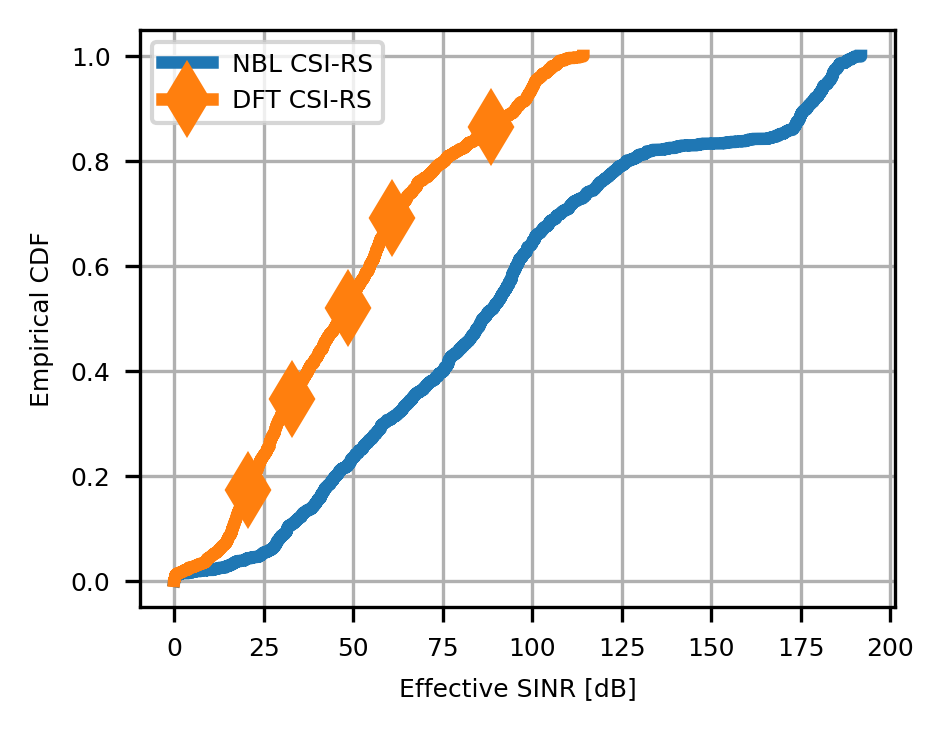

In [ ]:
# CSI-RS effective SINR
filt_algo_csi = filter_on_SE(algo_csi)
filt_dft_csi = filter_on_SE(dft_csi)

algos = ["NBL ", "DFT "]
markers = ["", "d", "^"]


ecdf = ECDF(logx((filt_algo_csi[2]))-logx(filt_algo_csi[3])/270)
plt.plot(ecdf.x, ecdf.y, markers[0]+"-", label=algos[0]+f"CSI-RS", markevery=8000)

ecdf = ECDF(logx((filt_dft_csi[2]))-logx(filt_dft_csi[3])/270)
plt.plot(ecdf.x, ecdf.y, markers[1]+"-", label=algos[1]+f"CSI-RS", markevery=12000, markersize=12)

plt.legend()
plt.xlabel("Effective SINR [dB]")
plt.ylabel("Empirical CDF")
plt.grid()

75.52726756455847 -18.819213148491443
29.856111170172127 -11.89636063637289


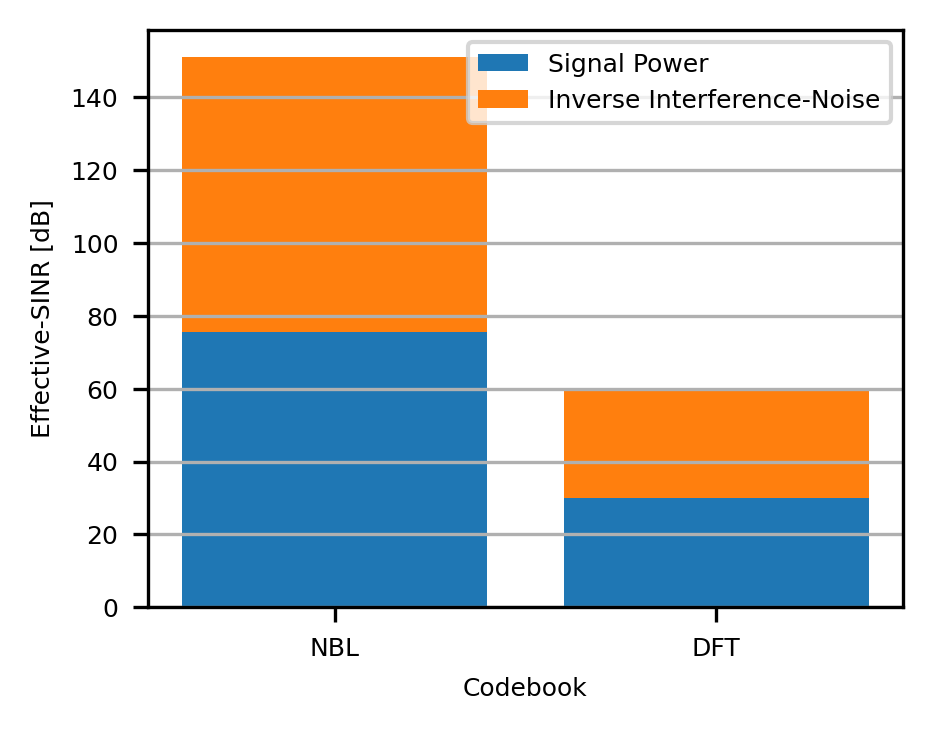

In [ ]:
# Split Signal to INR into dual-color bar graphs of S and 1/INR.
labels = ["NBL", "DFT"]

mean_S_algo = np.mean(logx(filt_algo_csi[2]/270))
mean_INR_algo = np.mean(logx(filt_algo_csi[3]/270))

mean_S_dft = np.mean(logx(filt_dft_csi[2]/270))
mean_INR_dft = np.mean(logx(filt_dft_csi[3]/270))

print(mean_S_algo, mean_INR_algo)
print(mean_S_dft, mean_INR_dft)

fig, ax = plt.subplots()
ax.bar(labels, [mean_S_algo, mean_S_dft], label='Signal Power')
ax.bar(labels, [mean_S_algo, mean_S_dft], bottom=[mean_S_algo, mean_S_dft],
       label='Inverse Interference-Noise')

plt.legend()
plt.ylabel("Effective-SINR [dB]")
plt.xlabel("Codebook")
ax.yaxis.grid(True)
# plt.savefig(path+f"results/CSI_stratified_SINR.pdf", bbox_inches='tight')

75.52726756455847 11.819213148491443
29.856111170172127 4.89636063637289


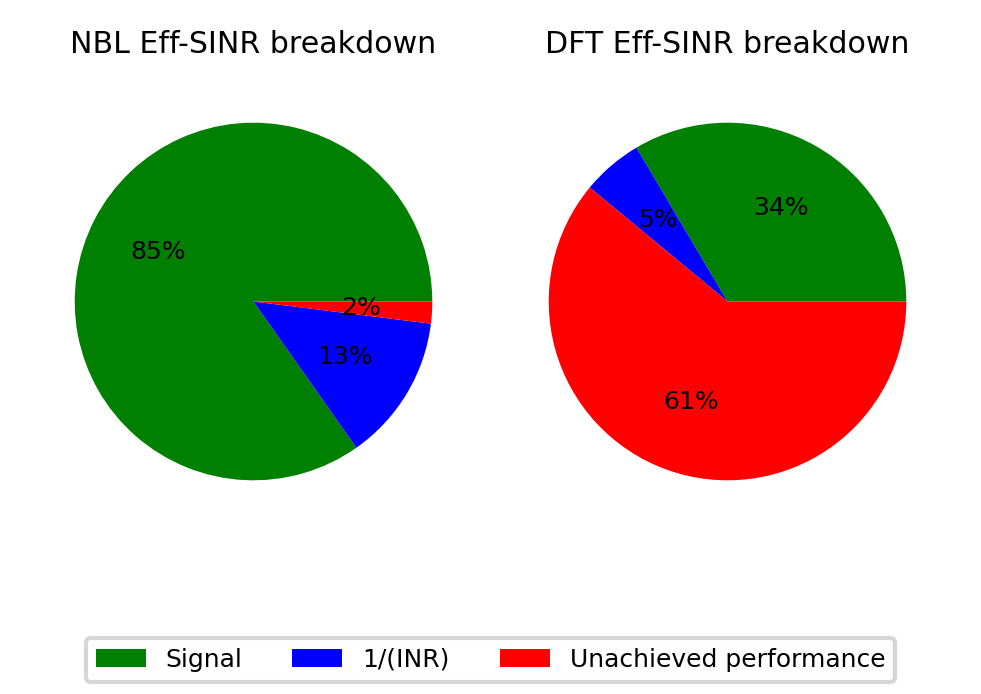

In [ ]:
# Split Signal to INR into dual-color bar graphs of S and 1/INR.
# labels = ["NBL", "DFT"]
labels = ["Signal", "1/(INR)", "Unachieved performance"]
colors = ['g', 'b', 'r']

mean_S_algo = np.mean(logx(filt_algo_csi[2]/270))
mean_INR_algo = -1*np.mean(logx(filt_algo_csi[3]/270))-7 # noise figure

mean_S_dft = np.mean(logx(filt_dft_csi[2]/270))
mean_INR_dft = -1*np.mean(logx(filt_dft_csi[3]/270))-7

mean_S_perf = np.mean(logx((2**(filt_algo_csi[1])-1)/270))

print(mean_S_algo, mean_INR_algo)
print(mean_S_dft, mean_INR_dft)

# switch to ratios: (S, I, uncaptured)
ratio_algo = np.array([mean_S_algo, mean_INR_algo, 0]) / mean_S_perf
ratio_algo[-1] = 1-np.sum(ratio_algo)

ratio_dft = np.array([mean_S_dft, mean_INR_dft, 0]) / mean_S_perf
ratio_dft[-1] = 1-np.sum(ratio_dft)

fig, ax = plt.subplots(1, 2)
ax[0].pie(ratio_algo, labels=['', '', ''], autopct='%.0f%%', colors=colors)
ax[1].pie(ratio_dft, labels=['', '', ''], autopct='%.0f%%', colors=colors)

ax[0].set_title("NBL Eff-SINR breakdown")
ax[1].set_title("DFT Eff-SINR breakdown")

fig.legend(labels, loc='lower center', ncol=3)
plt.tight_layout()
plt.savefig(path+f"results/CSI_stratified_SINR_circle.pdf", bbox_inches='tight')

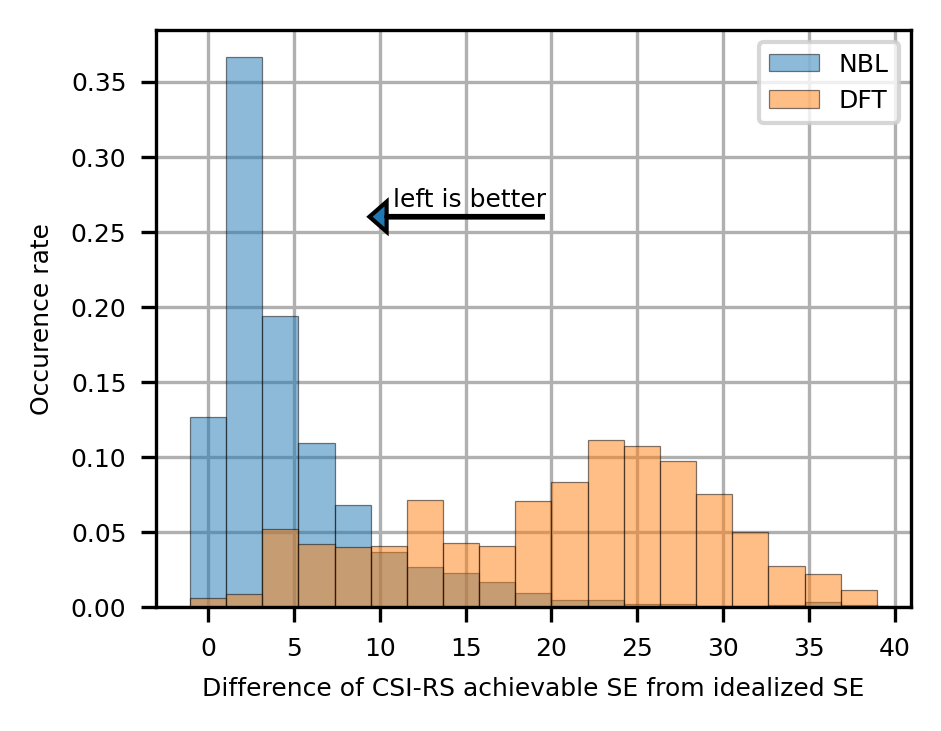

In [ ]:
# SE vs idealized SE
bins = np.linspace(0, 40, num=20)
fig, ax = plt.subplots()

delta_se = filt_algo_csi[1] - filt_algo_csi[0]
delta_dft = filt_dft_csi[1] - filt_dft_csi[0]
# plt.hist(delta_se, density=True, alpha=0.5, label="NBL")
# plt.hist(delta_dft, density=True, alpha=0.5, label="DFT")
plt.xlabel("Difference of CSI-RS achievable SE from idealized SE")
plt.grid()
ax.set_axisbelow(True)
plt.ylabel("Occurence rate");


results, edges = np.histogram(delta_se, density=True, bins=bins)
binWidth = edges[1] - edges[0]
plt.bar(edges[:-1], results*binWidth, binWidth, alpha=0.5, edgecolor='black', linewidth=0.3, label="NBL")

results, edges = np.histogram(delta_dft, density=True, bins=bins)
binWidth = edges[1] - edges[0]
plt.bar(edges[:-1], results*binWidth, binWidth, alpha=0.5, edgecolor='black', linewidth=0.3, label="DFT")
plt.legend()

plt.text(10.8, 0.267, "left is better")
plt.arrow(19.5, 0.26, -9.1, 0, head_width=0.02, head_length=1)

plt.savefig(path+f"results/CSI_SE_achievable.pdf", bbox_inches='tight')

In [ ]:
n_samples = 2000
pathgain = 6
scene_id = 'A'

filestring = path+f'eval_{pathgain}pg_scene_{scene_id}_{n_samples}_inputs_outputs_{16}_{16}_{Nx1}_{Ny1}_{Lmax}.pickle'

print(f"Loading {filestring}")
with open(filestring, "rb") as f:
    beamspace_set, channel_set, SVD_rate_set, scaler_set = pickle.load(f)

print(beamspace_set.shape, channel_set.shape)

Loading /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/eval_6pg_scene_A_2000_inputs_outputs_16_16_16_16_16.pickle
(2000, 17, 17, 96) (2000, 3, 20, 1, 20, 4, 256)


In [ ]:
AUTO = tf.data.AUTOTUNE
batch_size = 32

def make_tfds(beamspaces, channels, svd_pows, total_samples=1_000_000, batch_size=batch_size):
    # converts into a tfds for fast loading. If total_samples < len() then the datasets
    # are decreased in size up to total_samples
    in_beamspaces = tf.data.Dataset.from_tensor_slices(beamspaces[:total_samples])
    in_channels = tf.data.Dataset.from_tensor_slices(channels[:total_samples])
    out_svd_pows = tf.data.Dataset.from_tensor_slices(svd_pows[:total_samples])
    ds = tf.data.Dataset.zip((in_beamspaces, in_channels, out_svd_pows)).prefetch(AUTO).batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)
    return ds

test_ds = make_tfds(beamspace_set, channel_set, SVD_rate_set,)

2024-02-15 21:00:51.406183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19660800000 exceeds 10% of free system memory.
2024-02-15 21:00:58.281471: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19660800000 exceeds 10% of free system memory.


In [ ]:
# test_card = test_ds.cardinality().numpy()
test_card = 1

def test_esse(max_size=test_card):
    # need to make/pass in channel_subset
    nbl_se = np.zeros((max_size, batch_size, 20))
    SE_max = np.zeros((max_size, batch_size, 20))

    dft_se = np.zeros((max_size, batch_size, 20))
    for i, vds in enumerate(test_ds.take(max_size)):
        (beamspace, channel_set, SVD_rates) = vds
        channel_subset = channel_set[:, :, :, 0, 0, :, :]
        nbl_se[i] = val_esse_step(beamspace, channel_subset, channel_set, Ncsi=16)
        SE_max[i] = np.max(SVD_rates, axis=1)
        dft_se[i] = dft_esse_step(channel_subset, channel_set, Ncsi=16)
    return nbl_se, SE_max, dft_se



def val_esse_step(beamspace, channel_subset, channel_set, Ncsi=16):
    pred_beamspace = xbm.ssb_network(beamspace)
    ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax)
    p, m, b = tf_rsrp_rx_comb(channel_subset, ssb_codebook)
    csi_beamspace = xbm.csi_network(beamspace)
    csi_codebook = tf_deconvert_beamspace_csi(csi_beamspace, Lmax=Lmax, N=8, bg=4)
    csi_sub = tf_select_subset(ssb_codebook, csi_codebook, m, b, Ncsi)
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_subset, csi_sub, b)

    Heff = tf_apply_chan_F(csi_sub, ihat, b, channel_set) # 32, 20, 1, 20, 4, 4)
    Fdigital = tf_get_RZF(Heff.numpy()) #[... Np, U*Bg]
    # Fanalog = get_analog_precoder(csi_sub, b, ihat) # [... Nt, Np]
    ach_rate = tf.reduce_mean(tf_MU_MIMO_Opt(Heff, Fdigital, b), axis=[1, 2])
    return ach_rate


# @tf.function()
def tf_apply_chan_F(csi_sub, ihat, bhat, H):
    B, C, U, T, K, Nr, Nt = H.shape
    # For each user, get the effective beamformed channel in all cases
    beamformed_chan = tf.einsum('bcutkry,bcngy->bunctkrg', H, csi_sub) # [B, U, C, Ncsi, T, K, Nr, Bg]
    # now need to just return the gather based on bhat and ihat
    # beamformed_chan_bhat = tf.gather(beamformed_chan, bhat, axis=2, batch_dims=2) # [B, U, Ncsi, C, T, K, Nr, Bg]
    beamformed_chan_bhat_ihat = tf.gather(beamformed_chan, ihat, axis=2, batch_dims=2) # [B, U, C, T, K, Nr, Bg]
    return beamformed_chan_bhat_ihat


class DFT_method():
    def __init__(self, Nx=Nx, Ny=Ny, Lmax=Lmax, csi_per_ssb=4):
        self.Nx = Nx
        self.Ny = Ny
        self.Lmax = Lmax
        self.csi_per_ssb = csi_per_ssb

        self.SSB_codebook = DFT_codebook(n_beams=Lmax, Nx=Nx, Ny=Ny, OH=2, OV=2).transpose(2, 0, 1)
        self.CSI_codebook = DFT_codebook(n_beams=Lmax*csi_per_ssb, Nx=Nx, Ny=Ny, OH=csi_per_ssb, OV=csi_per_ssb).transpose(2, 0, 1)

    def predict(self, *args):
        return self.SSB_codebook, self.CSI_codebook

    def predict2(self, SSBRI, k_csi=8):
        pass # eventually implement the proportional selection algorithm here

# @tf.function()
def tf_get_RZF(Heff, Np=32):
    # print(Heff.shape)
    Heff = Heff.transpose([0, 2, 3, 4, 1, 5, 6])
    B, C, T, K, U, Nr, Bg = Heff.shape
    # U = min(U, Np//Bg)
    # need to separate by each of the C
    Fdigits = np.zeros((B, C, T, K, U, Bg, Bg), dtype=np.complex64)
    for b in range(B):
        for c in range(C):
            for t in range(T):
                for k in range(K):
                    # [U, Bg] channels
                    Fdigits[b, c, t, k, :, :, :] = zf_precoder(Heff[b, c, t, k]) # [U, Bg, Bg]
    Fdigits = Fdigits / (np.linalg.norm(Fdigits, axis=(-2, -1), keepdims=True)+1e-10)
    return Fdigits


@numba.jit(nopython=True)
def zf_precoder(H):
    U, Nr, Bg = H.shape
    precoders = np.zeros((U, Bg, Bg), dtype=np.complex64)
    HuHu = U * Bg * np.eye(Bg, dtype=np.complex64)
    for u in range(U):
        HuHu = HuHu + H[u].conj().T @ H[u]
    HuHuinv = np.linalg.pinv(HuHu)
    for u in range(U):
        num = HuHuinv @ H[u].conj().T
        precoders[u] = num
    return precoders


tf_nr_eye = tf.eye(Nr, dtype=tf.complex64)


def tf_MU_MIMO_Opt(Heff, Fdigital, bhat):
    # Heff is [B, U, C, T, K, Nr, Bg]
    # Fdigital is [B, C, T, K, U, Bg, Bg or Ns]
    # bhat is [B, U]
    # for every B, T, K do
    # HeffFdig FdigHeff for user u and c giving Nr x Bg matrix
    # same for all other u from all c
    # inverse and score
    B, U, C, T, K, _, Bg = Heff.shape
    tf_eye1 = tf.reshape(tf.eye(Nr, dtype=tf.complex64), [1, 1, 1, 1, Nr, Nr])
    tf_nr_eye_U_MIMO_Opt = tf.tile(tf_eye1, [B, T, K, U, 1, 1])
    HF = tf.einsum('buctkrg,bctkwgs->buwctkrs', Heff, Fdigital) # [B, U1, U2, C, T, K, Nr, Bg or Ns] # U1 is for channel, U2 is for transmission
    HFFH = tf.einsum('buwctkrs, buwctkas->bucwtkra', HF, tf.math.conj(HF)) # [B, U1, C, U2, T, K, Nr, Nr]
    serving_HFFH = tf.transpose(tf.gather(HFFH, bhat, axis=2, batch_dims=2), [0, 3, 4, 1, 2, 5, 6]) # [B, T, K, U1, U2, Nr, Nr] # serving cells only
    inter_HFFH = tf.reduce_sum(serving_HFFH, axis=4) #contains signal too, [B, T, K, U1, Nr, Nr]
    serving_HFFH = tf.einsum('btkuura->btkura', serving_HFFH) # [B, T, K, U, Nr, Nr] get diagonal elements
    inter_HFFH = inter_HFFH - serving_HFFH
    # now just need to go through for each user
    Cu = tflog2(tf.abs(tf.linalg.det(tf_nr_eye_U_MIMO_Opt + tf.matmul(serving_HFFH*U, tf_pinv(tf_nr_eye_U_MIMO_Opt+inter_HFFH/U))))) #[B, T, K, U]
    return Cu


# @tf.function()
def vect_mimo_opt(serving_hffh, inter_hfffh):
    signals = serving_HFFH[u, u, :, :]
    inter_u = inter_HFFH[u, :, :] - signal_power
    Cu = tflog2(tf.abs(tf.linalg.det(tf_nr_eye_U_MIMO_Opt + tf.matmul(D, tf_pinv(tf_nr_eye_U_MIMO_Opt+inter_u)))))

    
def get_analog_precoder(csi_sub, b, ihat, Np=32):
    # csi_sub is [B, C, Ncsi, Bg, Nt], b i s [B, U], ihat is [B, U]
    # need to get [B, C, Nt, U*Bg] with U*BG <= Np
    B, U = b.shape
    _, C, Ncsi, Bg, Nt = csi_sub.shape
    csi_sub_b = tf.gather(csi_sub, b, batch_dims=1, axis=1) # [B, C, U, Ncsi, Bg, Nt]
    csi_sub_b_ihat = tf.gather(csi_sub_b, ihat, batch_dims=2, axis=2) # [B, U, Bg, Nt]
    analog_1 = tf.gather(csi_sub_b_ihat, b, batch_dims=2)
    analog
    analog_precoders = tf.reshape(csi_sub_b_ihat, [B, U*Bg, Nt])


dft_algo = DFT_method()
dft_ssb_codebook = np.tile(dft_algo.SSB_codebook.reshape(1, 1, Lmax, Nt), [batch_size, C, 1, 1]) / np.sqrt(Nt)
csi_codebook_dft = gen_codebook(Nx, Ny, OH=2, OV=1)
dft_csi_codebook = np.tile(csi_codebook_dft.reshape(1, 1, Lmax, 8, 4, Nt), [batch_size, C, 1, 1, 1, 1])


def dft_esse_step(channel_subset, channel_set, Ncsi=16):
    p, m, b = tf_rsrp_rx_comb(channel_subset, dft_ssb_codebook)
    csi_sub = tf_select_subset(dft_ssb_codebook, dft_csi_codebook, m, b, Ncsi)
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_subset, csi_sub, b)
    Heff = tf_apply_chan_F(csi_sub, ihat, b, channel_set) # 32, 20, 1, 20, 4, 4)
    Fdigital = tf_get_RZF(Heff.numpy()) #[... Np, U*Bg]
    ach_rate = tf.reduce_mean(tf_MU_MIMO_Opt(Heff, Fdigital, b), axis=[1, 2])
    return ach_rate

Generating codebook for 16 from size 16x16x2x2
Generating codebook for 64 from size 16x16x4x4


In [ ]:
# del beamspace_set, channel_set, SVD_rate_set,
gc.collect()

0

In [ ]:
nbl_se, SE_max, dft_se = test_esse()

2024-02-15 17:48:17.536421: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19660800000 exceeds 10% of free system memory.


In [ ]:
esse_saving_path = path + f'results/scene_A_2000_esse_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"loading from {esse_saving_path}")

with open(esse_saving_path, "rb") as f:
    nbl_se, SE_max, dft_se = pickle.load(f)

loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_2000_esse_16_16_16_16_16.pickle


In [ ]:
def filter_on_se(algo_se, se_max):
    flat_algo_se = algo_se.flatten()
    flat_se_max = se_max.flatten()
    mask_se = flat_se_max > 1e-3
    algo_se = flat_algo_se[mask_se]
    return algo_se, flat_se_max[mask_se]

filt_ngl_se, filt_se_max = filter_on_se(nbl_se, SE_max)
filt_dft_se, filt_se_max = filter_on_se(dft_se, SE_max)

Text(0.5, 0, 'Difference in ESSE of NBL vs DFT codebooks [bps/Hz]')

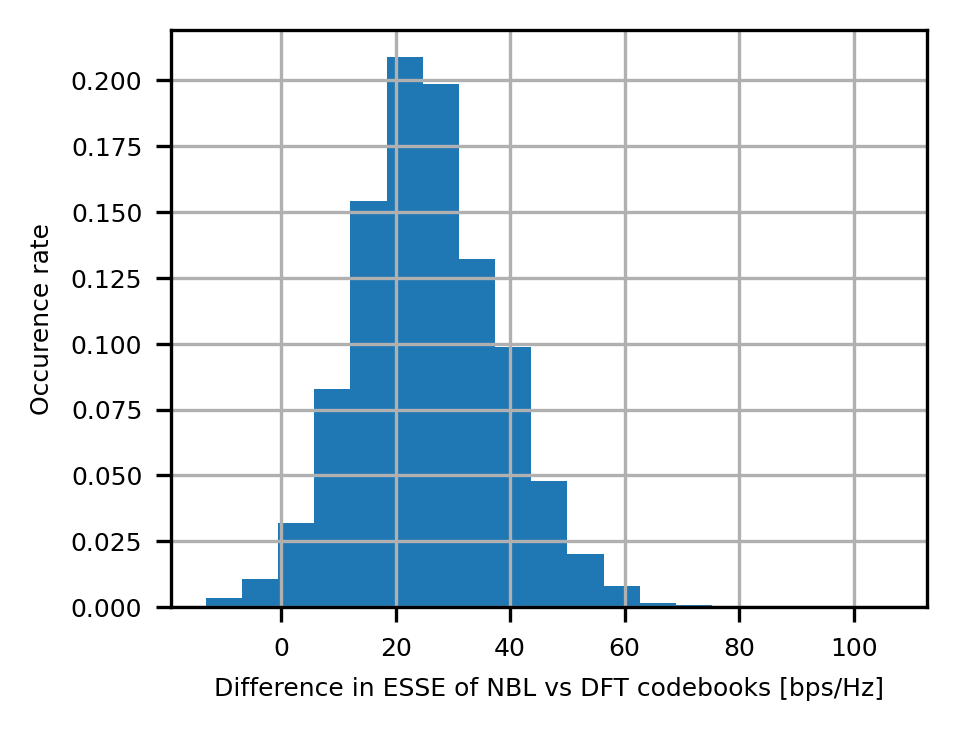

In [ ]:
bins = np.linspace(-10, 110, num=20)

delta_se = np.sum(nbl_se, axis=2).reshape(-1)
delta_dft = np.sum(dft_se, axis=2).reshape(-1)

results, edges = np.histogram(delta_se - delta_dft, density=True, bins=bins)
binWidth = edges[1] - edges[0]
plt.bar(edges[:-1], results*binWidth, binWidth)
plt.grid()

plt.ylabel("Occurence rate");
plt.xlabel("Difference in ESSE of NBL vs DFT codebooks [bps/Hz]")
# plt.savefig(path+f"results/ESSE.pdf", bbox_inches='tight')

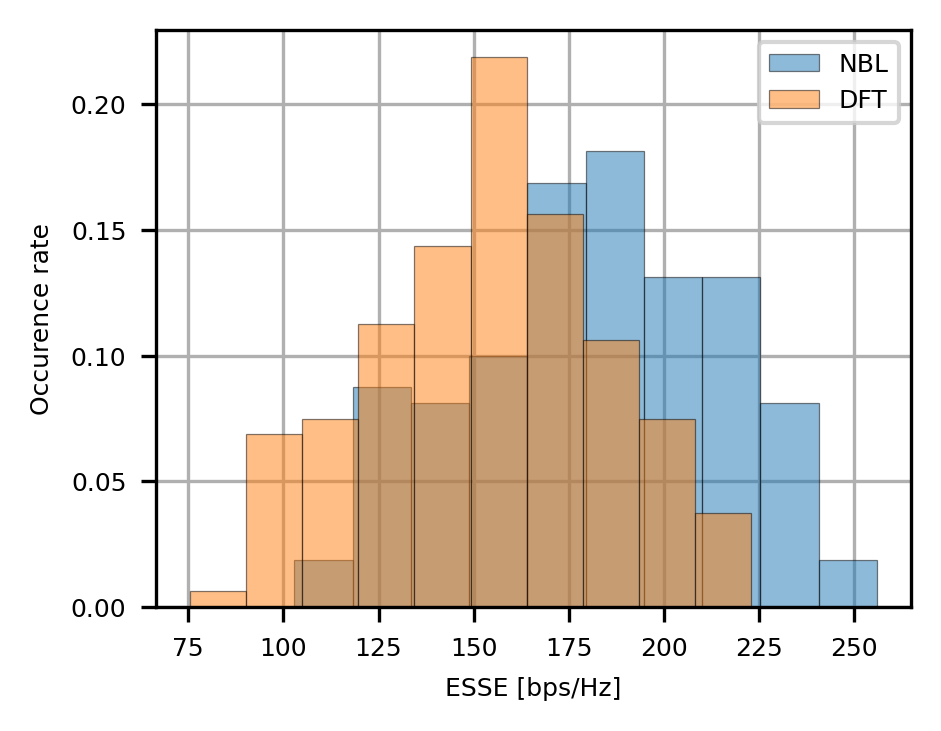

In [ ]:
# SE vs idealized SE
bins = np.linspace(0, 40, num=40)
fig, ax = plt.subplots()

delta_se = np.sum(nbl_se, axis=2).reshape(-1)
delta_dft = np.sum(dft_se, axis=2).reshape(-1)

plt.xlabel("ESSE [bps/Hz]")
plt.grid()
ax.set_axisbelow(True)
plt.ylabel("Occurence rate");


results, edges = np.histogram(delta_se, density=True)
binWidth = edges[1] - edges[0]
plt.bar(edges[:-1], results*binWidth, binWidth, alpha=0.5, edgecolor='black', linewidth=0.3, label="NBL")

results, edges = np.histogram(delta_dft, density=True)
binWidth = edges[1] - edges[0]
plt.bar(edges[:-1], results*binWidth, binWidth, alpha=0.5, edgecolor='black', linewidth=0.3, label="DFT")
plt.legend()

plt.savefig(path+f"results/ESSE.pdf", bbox_inches='tight')

In [ ]:
# ESSE with different geometries
esse_saving_path = path + f'results/geometry_scene_A_2000_esse_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"loading from {esse_saving_path}")

with open(esse_saving_path, "rb") as f:
    nbl_se2, SE_max2, dft_se2 = pickle.load(f)

delta_se2 = np.sum(nbl_se2, axis=2).reshape(-1)


loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/geometry_scene_A_2000_esse_16_16_16_16_16.pickle


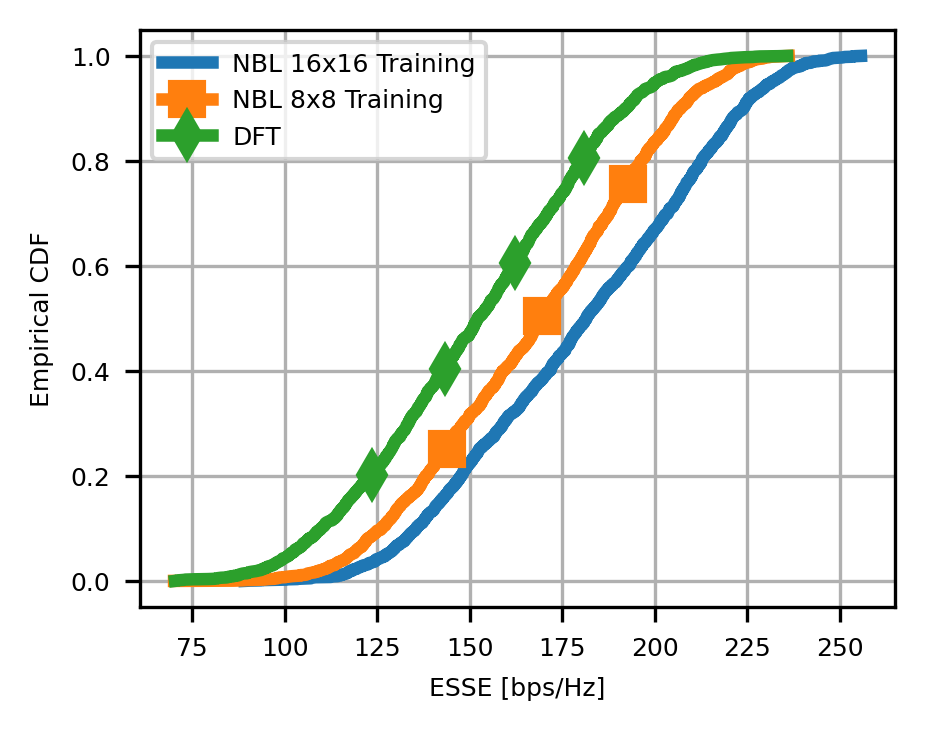

In [ ]:
ecdf = ECDF(delta_se)
plt.plot(ecdf.x-10, ecdf.y, label="NBL 16x16 Training")
ecdf = ECDF(delta_se2)
plt.plot(ecdf.x-10, ecdf.y, 's-', label="NBL 8x8 Training", markevery=500, markersize=8)

ecdf = ECDF(delta_dft)
plt.plot(ecdf.x-10, ecdf.y, 'd-', label="DFT", markevery=400, markersize=8)
plt.grid()
plt.legend()
plt.xlabel("ESSE [bps/Hz]")
plt.ylabel("Empirical CDF")
plt.savefig(path+f"results/ESSE_geometry.pdf", bbox_inches='tight')

loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/agnostic_scene_B_2000_esse_16_16_16_16_16.pickle
loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_B_2000_esse_16_16_16_16_16.pickle


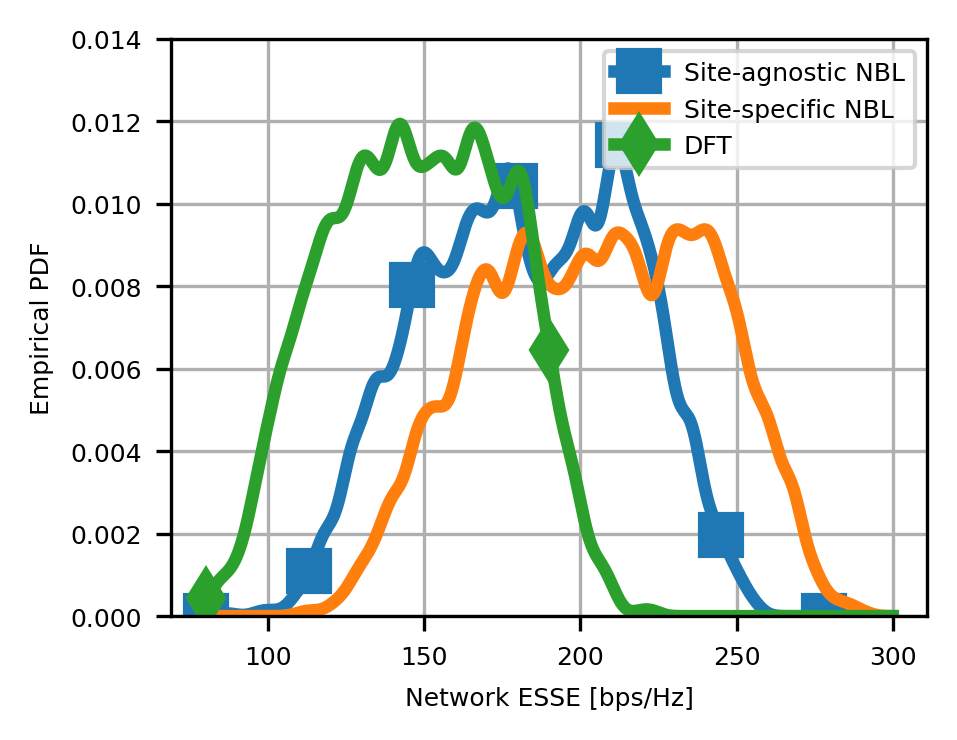

In [ ]:
# ESSE across the sites
matplotlib.rcParams['lines.markersize'] = 10

esse_saving_path = path + f'results/agnostic_scene_B_2000_esse_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"loading from {esse_saving_path}")
with open(esse_saving_path, "rb") as f:
    nbl_se, SE_max, dft_se = pickle.load(f)

esse_saving_path = path + f'results/scene_B_{2000}_esse_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"loading from {esse_saving_path}")
with open(esse_saving_path, "rb") as f:
    nbl_se2, SE_max2, dft_se2 = pickle.load(f)

delta_se = np.sum(nbl_se, axis=2).reshape(-1)
delta_se2 = np.sum(nbl_se2, axis=2).reshape(-1)
delta_dft = np.sum(dft_se, axis=2).reshape(-1)

pdf_plot(delta_se, xmin=80, xmax=300, label="Site-agnostic NBL", markers="-s", bw=3, markevery=300)
pdf_plot(delta_se2, xmin=80, xmax=300, label="Site-specific NBL", markers='-', bw=3, markevery=700)
pdf_plot(delta_dft, xmin=80, xmax=300, label="DFT", markers='-d', bw=3)
plt.grid()
plt.legend()
plt.xlabel("Network ESSE [bps/Hz]")
plt.ylabel("Empirical PDF")
plt.ylim([0, 0.014])
plt.savefig(path+f"results/ESSE_agnostic.pdf", bbox_inches='tight')

In [ ]:
esse_saving_path = path + f'results/agnostic_scene_B_2000_esse_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"Saving to {esse_saving_path}")

with open(esse_saving_path, "wb") as f:
    pickle.dump([nbl_se, SE_max, dft_se], f)

Saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/agnostic_scene_B_2000_esse_16_16_16_16_16.pickle


In [ ]:
@tf.function()
def tf_rsrp_rx_comb2(H, beams):
    # H is [?, U, Nr, Nt] and beams is [?, Lmax, Nt]
    rsrps = tf.abs(tf.norm(tf.einsum('burt,blt->burl', H, beams), axis=-2)) # * 20/Ktotal # [?, U, Lmax]
    return tf.reduce_max(rsrps, axis=2), tf.argmax(rsrps, axis=2) # returns shape [?, U], [?, U]
    # return rsrps


@tf.function()
def tf_deconvert_beamspace2(beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # convert from beamspace to beamformers
    complex_beamspace = tf.cast(beamspace[:, :, :, :Lmax], tf.complex64) + 1j * tf.cast(beamspace[:, :, :, Lmax:], tf.complex64) # [?, Nx, Ny, Lmax]
    beams = tf.einsum('nx, bnyl->bxyl', tf_U_NxNx_inv, tf.einsum('yn,bxnl->bxyl', tf_U_NyNy_inv, complex_beamspace))
    beams = tf.reshape(tf.transpose(beams, [0, 3, 1, 2]), [-1, Lmax, Nx*Ny])
    beams = beams / tf.norm(beams+1e-10, axis=-1, keepdims=True)
    return beams


@tf.function()
def beam_loss2(RSRP, svd_pow):
    return tf.reduce_mean(tf_10log10(svd_pow) - tf_10log10(RSRP))


@tf.function()
def unsup_loss2(rsrp):
    return -tf.reduce_mean(tf_10log10(rsrp))


@tf.function()
def tf_beamspace2loss2(H, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    # one function to get all the way to the loss calculation
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    svd_pow = tf_get_svd_pow(H)
    rsrp, ssbri = tf_rsrp_rx_comb(H, beams)
    loss = beam_loss(rsrp, svd_pow)
    return loss


@tf.function()
def unsup_tf_beamspace2loss2(Hest, beamspace, Lmax=Lmax, Nx1=Nx1, Ny1=Ny1):
    beams = tf_deconvert_beamspace(beamspace, Lmax, Nx1, Ny1)
    Hest = my_tf_const_mod(Hest, bits=2)
    rsrp, ssbri = tf_rsrp_rx_comb(Hest, beams)
    loss = unsup_loss(rsrp)
    return loss


@tf.function()
def tf_get_svd_pow2(channels):
    # channels is of size [?, U, Nr, Nt]
    Su = tf.linalg.svd(channels, compute_uv=False)
    return Su[:, :, 0]


@tf.function()
def tf_hybrid2(beamformers, Nb=b_phaseshifter):
    # beamformers is shape [?, Lmax, Nt], round to Nb bit phase shifts
    quant_beamformers = tf.grad_pass_through(my_tf_round)(beamformers)
    return quant_beamformers


def my_tf_round2(x, bits=b_phaseshifter):
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    return tf.cast(tf.round(tf.math.real(x) * multiplier) / multiplier, dtype=ctype) + 1j * tf.cast(tf.round(tf.math.imag(x) * multiplier) / multiplier, dtype=ctype)


@tf.function()
def my_tf_const_mod2(x, bits=b_phaseshifter):
    # previous was not constant modulus
    phases = tf.math.angle(x)
    phases = (phases - pi) / (2*pi)
    amplitudes = tf.abs(x)
    multiplier = tf.constant(2**bits, dtype=tf.float32)
    quant_phases = tf.cast(tf.round(phases * multiplier) / multiplier, dtype=ctype)
    quant_phases = quant_phases * 2 * pi - pi
    x_quant = tf.exp(1j * quant_phases)
    x_quant = x_quant / tf.norm(x_quant, axis=-1, keepdims=True)
    return x_quant

In [ ]:
# compare with XBM of our past paper

part_conv = partial(keras.layers.SeparableConv2D, kernel_size=(3, 3), activation='relu', padding='same', depth_multiplier=2)
dtype_con ='float32'

def get_ssb_network(Lmax=Lmax, output_dim=[Nx1, Ny1, Lmax*2], input_dim=[Nx1+1, Ny1+1, 2*Lmax]):
    inputs = keras.Input(input_dim)
    x = part_conv(filters=128)(inputs)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(filters=96)(x)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(filters=320)(x)
    x = keras.layers.MaxPool2D(padding='same')(x)
    x = part_conv(filters=128)(x)
    x = keras.layers.Dropout(rate=0.1)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(rate=0.4)(x)
    x = keras.layers.Dense(np.prod(output_dim), dtype=dtype_con)(x)  # kernel_regularizer='l1'
    y = keras.layers.Reshape(output_dim, dtype=dtype_con)(x)
    y = y / tf.linalg.norm(y+1e-10, axis=(1, 2), keepdims=True) * Nt
    model = keras.Model(inputs, y)
    print(model.summary())
    return model


def get_csi_network(Lmax=Lmax, csi_per_ssb=4):
    return get_ssb_network(Lmax, output_dim=[Nx1, Ny1, Lmax*csi_per_ssb*2])


class XBM_old(keras.Model):
    """ Class to overload the training and prediction methods for the XBM """
    def __init__(self, ssb_network=None, csi_network=None, scalers=None, csi_per_ssb=4, Nx=Nx, Ny=Ny):
        super().__init__()
        if ssb_network is None:
            self.ssb_networks = [get_ssb_network(), get_ssb_network(), get_ssb_network()]
        else:
            self.ssb_network = ssb_network
        if csi_network is None:
            self.csi_networks = [get_csi_network(), get_csi_network(), get_csi_network()]
        else:
            self.csi_network = csi_network
        self.scalers = scalers
        self.csi_per_ssb = csi_per_ssb
        self.Nx = Nx
        self.Ny = Ny

    def compile(self, ssb_optimizers, csi_optimizers, loss_func=None, **kwargs):
        super().compile(kwargs)
        self.ssb_optimizers = ssb_optimizers
        self.csi_optimizers = csi_optimizers
        self.loss_func = loss_func
        self.ssb_loss = keras.metrics.Mean(name="mean loss")
        self.csi_loss = keras.metrics.Mean(name="mean loss")

        for i in range(C):
            self.ssb_networks[i].compile(self.ssb_optimizers[i], loss=keras.losses.MSE)
            self.csi_networks[i].compile(self.csi_optimizers[i], loss=keras.losses.MSE)

    def train_step(self, inputs):
        # unpack inputs
        (beamspace, channel_set, SVD_powers) = inputs

        # loss calculation and gradients
        for c in range(C):
            with tf.GradientTape(persistent=True) as tape:
                pred_beamspace = self.ssb_networks[c](beamspace[:, :, :, c*32:(c+1)*32])
                ssb_loss = unsup_tf_beamspace2loss(channel_set[:, c], pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)
                ssb_variables = self.ssb_networks[c].trainable_variables
                ssb_grads = tape.gradient(ssb_loss, ssb_variables)

                csi_beamspace = self.csi_networks[c](beamspace[:, :, :, c*32:(c+1)*32])
                csi_loss = unsup_tf_beamspace2loss(channel_set[:, c], csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)
                csi_variables = self.csi_networks[c].trainable_variables
                csi_grads = tape.gradient(csi_loss, csi_variables)

            self.csi_optimizers[c].apply_gradients(zip(csi_grads, csi_variables))
            self.ssb_optimizers[c].apply_gradients(zip(ssb_grads, ssb_variables))
            self.ssb_loss.update_state(ssb_loss)
            self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def test_step(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        for c in range(C):
            pred_beamspace = self.ssb_networks[c](beamspace[:, :, :, c*32:(c+1)*32])
            ssb_loss = tf_beamspace2loss(channel_set[:, c], pred_beamspace, Lmax=Lmax, Nx1=self.Nx, Ny1=self.Ny)

            csi_beamspace = self.csi_networks[c](beamspace[:, :, :, c*32:(c+1)*32])
            csi_loss = tf_beamspace2loss(channel_set[:, c], csi_beamspace, Lmax=Lmax*self.csi_per_ssb, Nx1=Nx, Ny1=Ny)

            self.ssb_loss.update_state(ssb_loss)
            self.csi_loss.update_state(csi_loss)
        return {"ssb_loss" : self.ssb_loss.result(), 'csi_loss' : self.csi_loss.result()}

    def predict(self, inputs):
        (beamspace, channel_set, SVD_powers) = inputs
        pred_beamspace = self.ssb_network(beamspace)
        csi_beamspace = self.csi_network(beamspace)
        return pred_beamspace, csi_beamspace



In [ ]:
xbm_old = XBM_old()
opt1 = [keras.optimizers.Adam(learning_rate=1e-4) for i in range(C)]
opt2 = [keras.optimizers.Adam(learning_rate=1e-4) for i in range(C)]
xbm_old.compile(opt1, opt2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 17, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 separable_conv2d (SeparableCon  (None, 17, 17, 128)  8896       ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 9, 9, 128)    0           ['separable_conv2d[0][0]']       
                                                                                              

In [ ]:
for i in range(C):
    cpk_path = path + f'models/old_xbm_ssb/ckpt-{i}-1'
    checkpoint = tf.train.Checkpoint(optimizer=opt1[i], model=xbm_old.ssb_networks[i])
    stat1 = checkpoint.restore(cpk_path)

    cpk_path = path + f'models/old_xbm_csi/ckpt-{i}-1'
    checkpoint = tf.train.Checkpoint(optimizer=opt1[i], model=xbm_old.csi_networks[i])
    stat1 = checkpoint.restore(cpk_path)

In [ ]:
hist = xbm_old.fit(train_ds, epochs=100, validation_data=test_ds)

In [ ]:
for i in range(C):
    checkpoint1 = tf.train.Checkpoint(model=xbm_old.ssb_networks[i],optim=opt1[i])
    checkpoint2 = tf.train.Checkpoint(model=xbm_old.csi_networks[i],optim=opt2[i])

    checkpoint1.save(path + f'models/old_xbm_ssb/ckpt-{i}')
    checkpoint2.save(path + f'models/old_xbm_csi/ckpt-{i}')

In [ ]:
test_card = test_ds.cardinality().numpy()

def xbm_old_test_esse(max_size=test_card):
    nbl_se = np.zeros((max_size, batch_size, 20))
    for i, vds in enumerate(test_ds.take(max_size)):
        (beamspace, channel_set, SVD_rates) = vds
        channel_subset = channel_set[:, :, :, 0, 0, :, :]
        nbl_se[i] = val_xbm_esse_step(beamspace, channel_subset, channel_set, Ncsi=16)
    return nbl_se


def val_xbm_esse_step(beamspace, channel_subset, channel_set, Ncsi=16):
    pred_beamspace = tf.stack([tf.reshape(xbm_old.ssb_networks[i](beamspace[:, :, :, i*32:(i+1)*32]), [batch_size, Nx1, Ny1, 2*Lmax]) for i in range(C)], axis=-2)
    print(pred_beamspace.shape)
    ssb_codebook = tf_deconvert_beamspace(pred_beamspace, Lmax=Lmax)
    p, m, b = tf_rsrp_rx_comb(channel_subset, ssb_codebook)
    # [None, 16, 16, 128] -> [None, 16, 16, 4, 8, C, Lmax*2]
    csi_beamspace = tf.stack([tf.reshape(xbm_old.csi_networks[i](beamspace[:, :, :, i*32:(i+1)*32]), [batch_size, Nx1, Ny1, 4, 1, 2*Lmax]) for i in range(C)], axis=-2)
    csi_codebook = tf_deconvert_beamspace_csi(csi_beamspace, Lmax=Lmax, N=1, bg=4)
    csi_codebook = tf.reshape(csi_codebook, [batch_size, 3, -1, 4, Nt])
    p2, ihat, b2 = tf_rsrp_rx_comb_csistep(channel_subset, csi_codebook , b)

    Heff = tf_apply_chan_F(csi_codebook, ihat, b, channel_set) # 32, 20, 1, 20, 4, 4)
    Fdigital = tf_get_RZF(Heff.numpy()) #[... Np, U*Bg]
    ach_rate = tf.reduce_mean(tf_MU_MIMO_Opt(Heff, Fdigital, b), axis=[1, 2])
    return ach_rate

In [ ]:
esse_saving_path = path + f'results/old_xbm.pickle'
print(f"Saving to {esse_saving_path}")

with open(esse_saving_path, "wb") as f:
    pickle.dump(ach_rate, f)

Saving to /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/old_xbm.pickle


loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_2000_esse_16_16_16_16_16.pickle


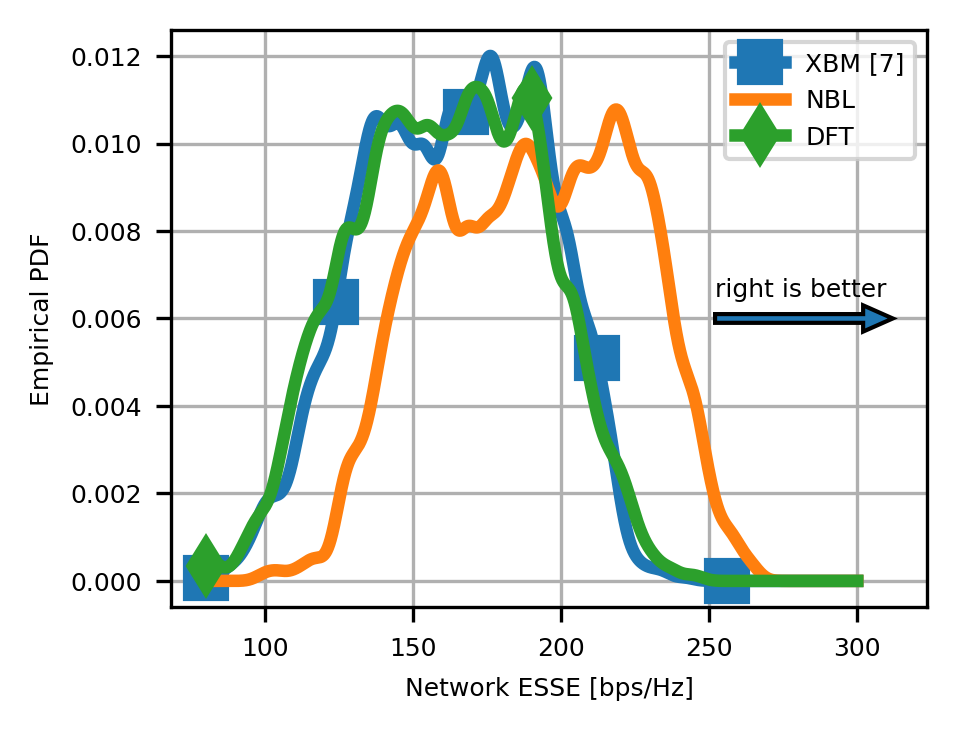

In [ ]:
# ESSE across the sites
esse_saving_path = path + f'results/scene_A_{2000}_esse_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}.pickle'
print(f"loading from {esse_saving_path}")
with open(esse_saving_path, "rb") as f:
    nbl_se, SE_max, dft_se = pickle.load(f)

with open(path + f'results/old_xbm.pickle', 'rb') as f:
    ach_rate = pickle.load(f)

delta_se = np.sum(nbl_se, axis=2).reshape(-1)
delta_se2 = np.sum(ach_rate, axis=2).reshape(-1)
delta_dft = np.sum(dft_se, axis=2).reshape(-1)

fig, ax = plt.subplots()
ax.set_axisbelow(True)

pdf_plot(delta_se2, xmin=80, xmax=300, label="XBM [7]", markers="-s", bw=3, markevery=400)
pdf_plot(delta_se, xmin=80, xmax=300, label="NBL", markers="-", bw=3, markevery=700)
pdf_plot(delta_dft, xmin=80, xmax=300, label="DFT", markers="-d", bw=3)
plt.grid()
plt.legend()
plt.xlabel("Network ESSE [bps/Hz]")
plt.ylabel("Empirical PDF")
plt.text(252, 0.0065, "right is better")
plt.arrow(252, 0.006, 50, 0, head_width=0.0006, head_length=10, width=0.0002)
# plt.ylim([0, 0.014])
plt.savefig(path+f"results/ESSE_ml_comparison.pdf", bbox_inches='tight')

## Reproduce

In [ ]:
algos = []
dfts = []
scene_id = 'A'

Lmax_set = [8, 16, 32]
for lmax in Lmax_set:
    if lmax <32:
        ssb_saving_path = path + f'results/scene_{scene_id}_{25000}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{lmax}.pickle'
    else:
        ssb_saving_path = path + f'results/scene_{scene_id}_{20000}_ssb_{Nx}_{Ny}_{Nx1}_{Ny1}_{lmax}.pickle'
    print(f"Loading from {ssb_saving_path}")

    with open(ssb_saving_path, "rb") as f:
        algo_ssb, dft_ssb, single_ant = pickle.load(f)
        algos.append(algo_ssb)
        dfts.append(dft_ssb)

Loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_25000_ssb_16_16_16_16_8.pickle
Loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_25000_ssb_16_16_16_16_16.pickle
Loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_20000_ssb_16_16_16_16_32.pickle


In [ ]:
len(algos[0])

3

NameError: name 'sing_rsrp' is not defined

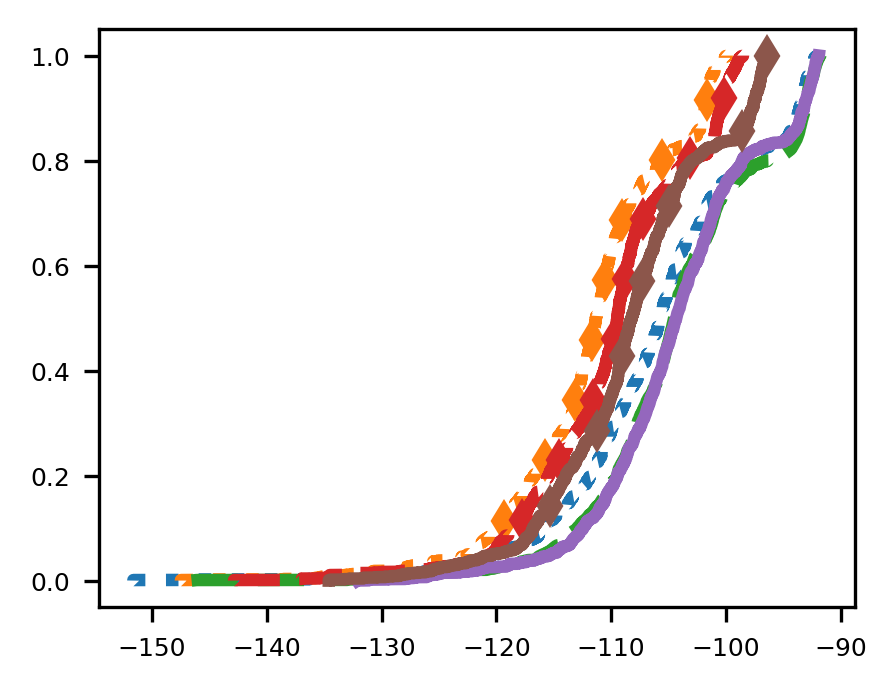

In [ ]:
algo_names = ["NBL ", "DFT ", "broadcast "]
markers = ["", "d", "o"]
lines = [":", "--", "-"]
factor_off = 10**11

for i in range(len(Lmax_set)):
    filt_algo, _, _ = filter_on_rsrp(algos[i])
    filt_dft, _, _ = filter_on_rsrp(dfts[i])
    ecdf = ECDF(logx(filt_algo/270*20/factor_off))
    plt.plot(ecdf.x, ecdf.y, markers[0]+lines[i], label=algo_names[0]+f"SSB Lmax={Lmax_set[i]}", markevery=8000)

    ecdf = ECDF(logx(filt_dft/270*20/factor_off))
    plt.plot(ecdf.x, ecdf.y, markers[1]+lines[i], label=algo_names[1]+f"SSB Lmax={Lmax_set[i]}", markevery=8000)

ecdf = ECDF(logx(sing_rsrp/270*20/factor_off))
plt.plot(ecdf.x, ecdf.y, markers[2]+"-", label=algo_names[2]+f"SSB", markevery=8000)

plt.legend()
plt.xlabel("RSRP [dBm]")
plt.ylabel("Empirical CDF")
plt.grid()
plt.xlim([-125, -90])


In [ ]:
algos = []
dfts = []

Lmax_set = [8, 16, 32]
for lmax in Lmax_set:
    ssb_saving_path = path + f'results/scene_{scene_id}_{n_samples}_csi_{Nx}_{Ny}_{Nx1}_{Ny1}_{Lmax}_NCSI_{lmax}.pickle'
    print(f"Loading from {ssb_saving_path}")

    with open(ssb_saving_path, "rb") as f:
        algo_ssb, dft_ssb = pickle.load(f)
        algos.append(algo_ssb)
        dfts.append(dft_ssb)

Loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_25000_csi_16_16_16_16_16_NCSI_8.pickle
Loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_25000_csi_16_16_16_16_16_NCSI_16.pickle
Loading from /media/ryan/Vol_2/SSB_Data/data_proc/network_XMIMO_1/results/scene_A_25000_csi_16_16_16_16_16_NCSI_32.pickle


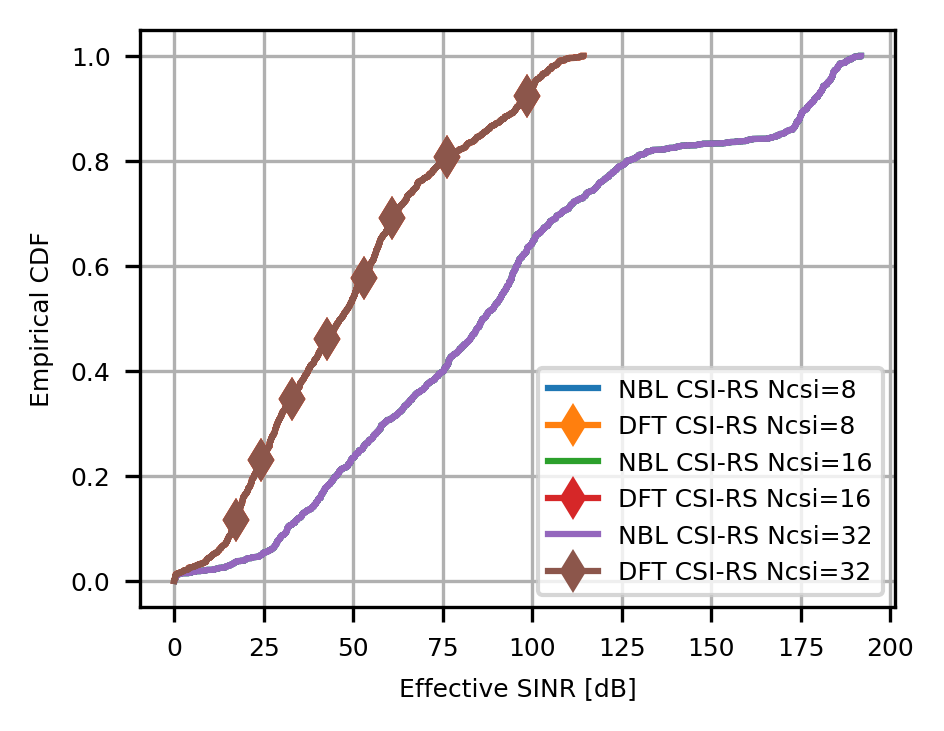

In [ ]:
algo_names = ["NBL ", "DFT "]
markers = ["", "d", "o"]
lines = [":", "--", "-"]

for i in range(len(Lmax_set)):
    filt_algo_csi = filter_on_SE(algos[i])
    filt_dft_csi = filter_on_SE(dfts[i])

    ecdf = ECDF(logx((filt_algo_csi[2]))-logx(filt_algo_csi[3])/270)
    plt.plot(ecdf.x, ecdf.y, markers[0]+"-", label=algo_names[0]+f"CSI-RS Ncsi={Lmax_set[i]}", markevery=8000)

    ecdf = ECDF(logx((filt_dft_csi[2]))-logx(filt_dft_csi[3])/270)
    plt.plot(ecdf.x, ecdf.y, markers[1]+"-", label=algo_names[1]+f"CSI-RS Ncsi={Lmax_set[i]}", markevery=8000)

    plt.legend()
    plt.xlabel("Effective SINR [dB]")
    plt.ylabel("Empirical CDF")
    plt.grid()